In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import time
import os
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg


import scikit_posthocs as sp
import statsmodels.api as sm
from scipy.stats import boxcox
#from statannotations.Annotator import Annotator
from scipy.stats import pearsonr
import docx
from docx.enum.section import WD_ORIENT
from docx.enum.section import WD_SECTION
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.shared import Pt



In [2]:
# Function to convert df to docx table format

def df_to_table(doc, df):
    # Add a table to the end and create a reference variable
    t = doc.add_table(df.shape[0]+1, df.shape[1])

    # Make sure df is rounded 
    df = df.round(2)

    # Make sure table is auto fit
    for cell in t._cells:
        cell.width = docx.shared.Inches(1.0)
    
    # Set the style of the table
    table_style = doc.styles['Table Grid']

    # Add the header rows.
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    # Add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])
    
    return doc

# Eye tracking analyses 2025 Visual Search

In [3]:
# Papermill parameters
outlier_rem = True  
date = "09_03_2025"
derivative = "standard" # "standard" or "pilot"


In [4]:
# Date 
files_date= "0_09_32025"

## Data loading

In [7]:
# Load all the files
vs_p = glob.glob('/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/experimental_files-2/*.txt')
vs_control = glob.glob('/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/*.txt')
all_files = vs_control + vs_p
go_files = all_files
p1= f"Total files including tests: " + str(len(go_files))
print (p1)

go_files


Total files including tests: 136


['/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/Q1K_023_Z_VS.txt',
 '/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/Q1K_028_Z_VS.txt',
 '/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/Q1K_029_Z_VS.txt',
 '/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/Q1K_017_Z_VS.txt',
 '/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/Q1K_024_Z_VS.txt',
 '/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/Q1K_052_Z_VS.txt',
 '/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/Q1K_010_Z_VS.txt',
 '/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/Q1K_032_Z_VS.txt',
 '/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/Q1K_033_Z_VS.txt',
 '/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/Q1K_038_Z_VS.txt',
 '/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/control_files/Q1K_006_Z_VS.txt',

In [8]:
# Load all the files into a single dataframe
df = []
for file in all_files:
    file_name = file.split('/')[-1]
    file_name = "_".join(file_name.split('_')[:-1])
    subject_df = pd.read_csv(file, delimiter = "\t")
    subject_df['subject'] = file_name
    df.append(subject_df)
df = pd.concat(df, axis=0)

df

,Session_Name_,Trial_Index_,Trial_Recycled_,VS_SAC_RT,VS_VALID,sub_task_blocking,task,condition,detail,dl_video,vs_location_list,subject
0,023_vs_1,1,False,301,True,1,VS,Five,Single_Slice,Blank.mov,"(7, 2, 9, 14, 4)",Q1K_023_Z
1,023_vs_1,2,False,779,True,2,VS,Nine,Single_Slice,Blank.mov,"(1, 15, 2, 10, 6, 11, 7, 4, 16)",Q1K_023_Z
2,023_vs_1,3,False,-1,False,3,VS,Thirteen,Single_Slice,Blank.mov,"(3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)",Q1K_023_Z
3,023_vs_1,4,False,248,True,4,VS,Five,Single_Apple,Blank.mov,"(10, 0, 14, 3, 2)",Q1K_023_Z
4,023_vs_1,5,False,3534,True,5,VS,Nine,Single_Apple,Blank.mov,"(3, 10, 0, 13, 9, 16, 14, 5, 7)",Q1K_023_Z
...,...,...,...,...,...,...,...,...,...,...,...,...
25,Q1121_M1,26,False,170,True,7,VS,Nine,Conjunction,Blank.mov,"(0, 3, 11, 13, 7, 8, 5, 1, 6)",1121M1
26,Q1121_M1,27,False,199,True,7,VS,Nine,Conjunction,Blank.mov,"(13, 8, 7, 5, 0, 4, 16, 11, 1)",1121M1
27,Q1121_M1,28,False,229,True,7,VS,Thirteen,Conjunction,Blank.mov,"(15, 9, 5, 8, 0, 11, 12, 4, 7, 6, 13, 2, 14)",1121M1
28,Q1121_M1,29,False,258,True,7,VS,Thirteen,Conjunction,Blank.mov,"(6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)",1121M1


In [9]:
df["detail"] = df["detail"].replace({"Single_Apple": "Single", "Single_Slice": "Single"})
df

,Session_Name_,Trial_Index_,Trial_Recycled_,VS_SAC_RT,VS_VALID,sub_task_blocking,task,condition,detail,dl_video,vs_location_list,subject
0,023_vs_1,1,False,301,True,1,VS,Five,Single,Blank.mov,"(7, 2, 9, 14, 4)",Q1K_023_Z
1,023_vs_1,2,False,779,True,2,VS,Nine,Single,Blank.mov,"(1, 15, 2, 10, 6, 11, 7, 4, 16)",Q1K_023_Z
2,023_vs_1,3,False,-1,False,3,VS,Thirteen,Single,Blank.mov,"(3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)",Q1K_023_Z
3,023_vs_1,4,False,248,True,4,VS,Five,Single,Blank.mov,"(10, 0, 14, 3, 2)",Q1K_023_Z
4,023_vs_1,5,False,3534,True,5,VS,Nine,Single,Blank.mov,"(3, 10, 0, 13, 9, 16, 14, 5, 7)",Q1K_023_Z
...,...,...,...,...,...,...,...,...,...,...,...,...
25,Q1121_M1,26,False,170,True,7,VS,Nine,Conjunction,Blank.mov,"(0, 3, 11, 13, 7, 8, 5, 1, 6)",1121M1
26,Q1121_M1,27,False,199,True,7,VS,Nine,Conjunction,Blank.mov,"(13, 8, 7, 5, 0, 4, 16, 11, 1)",1121M1
27,Q1121_M1,28,False,229,True,7,VS,Thirteen,Conjunction,Blank.mov,"(15, 9, 5, 8, 0, 11, 12, 4, 7, 6, 13, 2, 14)",1121M1
28,Q1121_M1,29,False,258,True,7,VS,Thirteen,Conjunction,Blank.mov,"(6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)",1121M1


In [10]:
# Assuming df is your DataFrame
df['first_location'] = df['vs_location_list'].apply(lambda x: eval(x)[0])

In [11]:
## keep only the relevant columns
df = df[["subject","Trial_Index_","condition", "detail", "VS_SAC_RT", "VS_VALID", "vs_location_list", 'first_location']]

In [12]:
# Load demographic data

demo_df = pd.read_csv("/Users/audrey-annebeaudry/Desktop/OneDrive_1_2025-01-12/q1k_attempted_demographic_ouputs_2025_03_02.csv")

In [13]:
# keep only the subjects that are in the go_df 
demo_df = demo_df[demo_df['bids_id'].isin(df['subject'])]

In [14]:
# Keep important columns
demo_df = demo_df[["age", "group", "site", "sex", "asd",  "bids_id", "adhd", "record_id"]]

# Change ASD from 0, 1 to "asd" and "control"
demo_df.loc[:, "asd"] = demo_df["asd"].replace({"0": "control", "1": "asd"})

In [15]:
# Create column for age group
demo_df['age_group'] = pd.cut(demo_df['age'], bins=[0, 18, 100], labels=['child', 'adult'])

In [16]:
demo_df["sex"] = demo_df["sex"].replace({"Female": "female", "Male": "male"})

In [17]:
demo_df

,age,group,site,sex,asd,bids_id,adhd,record_id,age_group
2,30.215656,proband,mni,female,control,0042P,0,42,adult
12,40.209016,proband,hsj,female,control,0062P,0,62,adult
15,12.345223,sibling,hsj,male,asd,0064S1,NaN,65,child
16,38.204754,mother,hsj,female,control,0064M1,0,66,adult
22,19.337837,sibling,hsj,female,asd,0086S1,NaN,87,adult
...,...,...,...,...,...,...,...,...,...
238,9.637547,sibling,hsj,female,control,1140S1,NaN,525-1142,child
242,16.233165,proband,hsj,male,asd,1147P,0,525-1147,child
244,50.643180,father,hsj,male,control,1147F1,0,525-1149,adult
245,13.254322,sibling,hsj,male,control,1147S1,0,525-1150,child


In [18]:
# Assuming you have the DataFrame named demo_df
demo_df['adhd'] = demo_df['adhd'].fillna('0')  # Replace NaN with 0
demo_df['adhd'] = demo_df['adhd'].replace('Suspected', '1')  # Replace 'suspected' with 1

In [19]:
demo_df["asd"] = demo_df["asd"].fillna("Unknown")

In [20]:
unknown_asd = demo_df[demo_df['asd'] == 'Unknown']  # Filter rows where 'asd' is 'unknown'


In [23]:
# Remove rows where 'asd' column has 'Missing if impossible to confirm'
demo_df = demo_df[demo_df['asd'] != 'Missing if impossible to confirm']


In [24]:
# Assuming your DataFrame is named demo_df
def assign_diagnosis_group(row):
    if row['asd'] == 'asd':  # If ASD is 1, assign 'asd' regardless of ADHD
        return 'asd'
    elif row['adhd'] == '1':  # If ADHD is 1, assign 'adhd'
        return 'adhd'
    else:
        return 'control'  # Default to control if neither ASD nor ADHD is 1

# Apply the function to each row to create the 'diagnosis_group' column
demo_df['diagnosis_group'] = demo_df.apply(assign_diagnosis_group, axis=1)

# Print the updated DataFrame to verify the new column
demo_df

,age,group,site,sex,asd,bids_id,adhd,record_id,age_group,diagnosis_group
2,30.215656,proband,mni,female,control,0042P,0,42,adult,control
12,40.209016,proband,hsj,female,control,0062P,0,62,adult,control
15,12.345223,sibling,hsj,male,asd,0064S1,0,65,child,asd
16,38.204754,mother,hsj,female,control,0064M1,0,66,adult,control
22,19.337837,sibling,hsj,female,asd,0086S1,0,87,adult,asd
...,...,...,...,...,...,...,...,...,...,...
238,9.637547,sibling,hsj,female,control,1140S1,0,525-1142,child,control
242,16.233165,proband,hsj,male,asd,1147P,0,525-1147,child,asd
244,50.643180,father,hsj,male,control,1147F1,0,525-1149,adult,control
245,13.254322,sibling,hsj,male,control,1147S1,0,525-1150,child,control


In [25]:
for subject in df.subject.unique():
    if subject in demo_df.bids_id.unique():
        continue
    else: 
        print (f"Flag '{subject}'") #STILL NEED TO ADD THE CONTROL DOCUMENTATION!

Flag 'Q1K_023_Z'
Flag 'Q1K_028_Z'
Flag 'Q1K_029_Z'
Flag 'Q1K_017_Z'
Flag 'Q1K_024_Z'
Flag 'Q1K_052_Z'
Flag 'Q1K_010_Z'
Flag 'Q1K_032_Z'
Flag 'Q1K_033_Z'
Flag 'Q1K_038_Z'
Flag 'Q1K_006_Z'
Flag 'Q1K_015_Z'
Flag 'Q1K_014_Z'
Flag 'Q1K_020_Z'
Flag 'Q1K_002_Z'
Flag 'Q1K_008_Z'
Flag 'Q1K_009_Z'
Flag 'Q1K_096_Z'
Flag 'Q1K_004_Z'
Flag 'Q1K_031_Z'
Flag 'Q1K_030_Z'
Flag 'Q1K_012_Z'
Flag 'Q1K_013_Z'
Flag 'Q1K_026_Z'
Flag 'Q1K_027_Z'
Flag 'Q1K_018_Z'
Flag '1009M1'


## Exploratory Analysis

In [28]:
# Assuming demo_df is already defined as the demographic dataframe

# Summarize data by diagnosis groups
summary_table = demo_df.groupby("diagnosis_group").agg(
    n=("diagnosis_group", "count"),
    male=("sex", lambda x: (x == "male").sum()),
    female=("sex", lambda x: (x == "female").sum()),
    mean_age=("age", "mean"),
    std_age=("age", "std"),
    hsj=("site", lambda x: (x == "hsj").sum()),
    mni=("site", lambda x: (x == "mni").sum()),
    adults=("age_group", lambda x: (x == "adult").sum()),
    children=("age_group", lambda x: (x == "child").sum()),
).reset_index()

# Add combined row for all participants
all_participants = {
    "diagnosis_group": "combined",
    "n": summary_table["n"].sum(),
    "male": summary_table["male"].sum(),
    "female": summary_table["female"].sum(),
    "mean_age": demo_df["age"].mean(),
    "std_age": demo_df["age"].std(),
    "hsj": summary_table["hsj"].sum(),
    "mni": summary_table["mni"].sum(),
    "adults": summary_table["adults"].sum(),
    "children": summary_table["children"].sum(),
}

summary_table = pd.concat(
    [pd.DataFrame([all_participants]), summary_table], ignore_index=True
)

# Create combined and percentage columns
summary_table["sex (M:F)"] = summary_table["male"].astype(str) + ":" + summary_table["female"].astype(str)
summary_table["sex % (M:F)"] = (
    (summary_table["male"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["female"] / summary_table["n"] * 100).round(2).astype(str)
)

summary_table["site (HSJ:MNI)"] = summary_table["hsj"].astype(str) + ":" + summary_table["mni"].astype(str)
summary_table["site % (HSJ:MNI)"] = (
    (summary_table["hsj"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["mni"] / summary_table["n"] * 100).round(2).astype(str)
)

# Drop intermediate columns to keep the table clean
summary_table.drop(columns=["male", "female", "hsj", "mni"], inplace=True)

# Rename columns for better clarity
summary_table.rename(
    columns={
        "diagnosis_group": "Diagnosis Group",
        "n": "Total Participants",
        "mean_age": "Mean Age",
        "std_age": "Age SD",
        "adults": "Adults",
        "children": "Children",
    },
    inplace=True,
)


In [29]:
summary_table=summary_table.round(2)
summary_table

,Diagnosis Group,Total Participants,Mean Age,Age SD,Adults,Children,sex (M:F),sex % (M:F),site (HSJ:MNI),site % (HSJ:MNI)
0,combined,106,28.64,16.22,62,44,46:60,43.4:56.6,67:39,63.21:36.79
1,adhd,13,23.98,14.88,6,7,6:7,46.15:53.85,10:3,76.92:23.08
2,asd,22,13.75,5.41,3,19,13:9,59.09:40.91,11:11,50.0:50.0
3,control,71,34.11,15.61,53,18,27:44,38.03:61.97,46:25,64.79:35.21


In [30]:
df = df[["VS_SAC_RT", "VS_VALID", "condition", "detail", "vs_location_list", 'first_location', "subject", "Trial_Index_"]]
df

,VS_SAC_RT,VS_VALID,condition,detail,vs_location_list,first_location,subject,Trial_Index_
0,301,True,Five,Single,"(7, 2, 9, 14, 4)",7,Q1K_023_Z,1
1,779,True,Nine,Single,"(1, 15, 2, 10, 6, 11, 7, 4, 16)",1,Q1K_023_Z,2
2,-1,False,Thirteen,Single,"(3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)",3,Q1K_023_Z,3
3,248,True,Five,Single,"(10, 0, 14, 3, 2)",10,Q1K_023_Z,4
4,3534,True,Nine,Single,"(3, 10, 0, 13, 9, 16, 14, 5, 7)",3,Q1K_023_Z,5
...,...,...,...,...,...,...,...,...
25,170,True,Nine,Conjunction,"(0, 3, 11, 13, 7, 8, 5, 1, 6)",0,1121M1,26
26,199,True,Nine,Conjunction,"(13, 8, 7, 5, 0, 4, 16, 11, 1)",13,1121M1,27
27,229,True,Thirteen,Conjunction,"(15, 9, 5, 8, 0, 11, 12, 4, 7, 6, 13, 2, 14)",15,1121M1,28
28,258,True,Thirteen,Conjunction,"(6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)",6,1121M1,29


In [31]:
df["subject"] = df["subject"].astype(str)
demo_df["bids_id"] = demo_df["bids_id"].astype(str)
df["subject"] = df["subject"].str.strip()
demo_df["bids_id"] = demo_df["bids_id"].str.strip()
demo_df["diagnosis_group"] = demo_df["diagnosis_group"].astype(str).replace("nan", np.nan)

In [32]:
## Merge the go_df and demo_df
demo_df = demo_df.rename(columns = {'bids_id' : 'subject'})
df = pd.merge(df, demo_df, on="subject", how="inner")
#print(df["asd"].unique())

## Differences in reaction time 

In [35]:
#Remove failed trials, those with negative reaction times and reaction times abova 1 second
rt_df= df[df.VS_VALID]

#rt_df=rt_df.loc[(rt_df.VS_SAC_RT>0)] #& (rt_df.VS_SAC_RT<1000)]

In [36]:
rt_df.VS_VALID.value_counts()

VS_VALID
True    2740
Name: count, dtype: int64

In [38]:

rt_sub = pd.DataFrame(rt_df).reset_index().rename(columns={"VS_SAC_RT": "rt"})

# Calculate descriptive statistics including the mean
rt_decriptive_stats = rt_sub.groupby(["condition", "detail"]).rt.agg(['mean', 'std', 'min', 'max']).reset_index()

# Round to 2 decimal places
rt_decriptive_stats = rt_decriptive_stats.round(2)


In [40]:
rt_sub["diagnosis_group"] = rt_sub["diagnosis_group"].fillna("Unknown")
rt_sub


,index,rt,VS_VALID,condition,detail,vs_location_list,first_location,subject,Trial_Index_,age,group,site,sex,asd,adhd,record_id,age_group,diagnosis_group
0,0,628,True,Five,Single,"(7, 2, 9, 14, 4)",7,1009S1,1,13.571805,sibling,hsj,female,control,0,525-1011,child,control
1,1,344,True,Nine,Single,"(1, 15, 2, 10, 6, 11, 7, 4, 16)",1,1009S1,2,13.571805,sibling,hsj,female,control,0,525-1011,child,control
2,2,244,True,Thirteen,Single,"(3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)",3,1009S1,3,13.571805,sibling,hsj,female,control,0,525-1011,child,control
3,3,931,True,Five,Single,"(10, 0, 14, 3, 2)",10,1009S1,4,13.571805,sibling,hsj,female,control,0,525-1011,child,control
4,4,197,True,Nine,Single,"(3, 10, 0, 13, 9, 16, 14, 5, 7)",3,1009S1,5,13.571805,sibling,hsj,female,control,0,525-1011,child,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2735,3204,170,True,Nine,Conjunction,"(0, 3, 11, 13, 7, 8, 5, 1, 6)",0,1121M1,26,39.225994,mother,hsj,female,control,0,525-1123,adult,control
2736,3205,199,True,Nine,Conjunction,"(13, 8, 7, 5, 0, 4, 16, 11, 1)",13,1121M1,27,39.225994,mother,hsj,female,control,0,525-1123,adult,control
2737,3206,229,True,Thirteen,Conjunction,"(15, 9, 5, 8, 0, 11, 12, 4, 7, 6, 13, 2, 14)",15,1121M1,28,39.225994,mother,hsj,female,control,0,525-1123,adult,control
2738,3207,258,True,Thirteen,Conjunction,"(6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)",6,1121M1,29,39.225994,mother,hsj,female,control,0,525-1123,adult,control


### Outlier detection for each subject

In [41]:
# Remove outliers for each subject

n_before = len(rt_sub)
print ("Toral number of trials before removal: ", len(rt_sub))
summary_outliers= []
for sub in rt_df.subject.unique():
    df=rt_df.loc[rt_df.subject==sub]
    # Function to perform outlier removal using IQR
    Q1 = df["VS_SAC_RT"].quantile(0.25)
    Q3 = df["VS_SAC_RT"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR # Should be 1.5 but can be adjusted to 3
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df["VS_SAC_RT"] >= lower_bound) & (df["VS_SAC_RT"] <= upper_bound)]
    df_removed = df[(df["VS_SAC_RT"] < lower_bound) | (df["VS_SAC_RT"] > upper_bound)]
    summary_outliers.append(df_removed)
    # Remove the outlier trials from the main dataframe
    if outlier_rem:
        rt_sub = rt_sub[~rt_sub.index.isin(df_removed.index)]
   
    print( "Subject: ", sub, "n trials removed: ", len(df_removed), "% left: ", len(df_filtered)/len(df)*100)

print ("Toral number of trials after removal: ", len(rt_sub))
n_after = len(rt_sub)
summary_outliers_df = pd.concat(summary_outliers, axis=0)


Toral number of trials before removal:  2740
Subject:  1009S1 n trials removed:  2 % left:  93.33333333333333
Subject:  0179P n trials removed:  7 % left:  76.66666666666667
Subject:  0216M1 n trials removed:  2 % left:  93.33333333333333
Subject:  0179M1 n trials removed:  7 % left:  76.66666666666667
Subject:  0146P n trials removed:  0 % left:  100.0
Subject:  0093O1 n trials removed:  1 % left:  90.9090909090909
Subject:  1073M1 n trials removed:  6 % left:  80.0
Subject:  1037F1 n trials removed:  6 % left:  77.77777777777779
Subject:  1106M1 n trials removed:  2 % left:  93.10344827586206
Subject:  1114P n trials removed:  0 % left:  100.0
Subject:  0223M1 n trials removed:  1 % left:  92.85714285714286
Subject:  0196M1 n trials removed:  5 % left:  82.75862068965517
Subject:  1134S1 n trials removed:  4 % left:  86.66666666666667
Subject:  0162S1 n trials removed:  3 % left:  90.0
Subject:  0200M1 n trials removed:  1 % left:  96.66666666666667
Subject:  0265P n trials removed: 

In [42]:
rt_sub

,index,rt,VS_VALID,condition,detail,vs_location_list,first_location,subject,Trial_Index_,age,group,site,sex,asd,adhd,record_id,age_group,diagnosis_group
1,1,344,True,Nine,Single,"(1, 15, 2, 10, 6, 11, 7, 4, 16)",1,1009S1,2,13.571805,sibling,hsj,female,control,0,525-1011,child,control
2,2,244,True,Thirteen,Single,"(3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)",3,1009S1,3,13.571805,sibling,hsj,female,control,0,525-1011,child,control
4,4,197,True,Nine,Single,"(3, 10, 0, 13, 9, 16, 14, 5, 7)",3,1009S1,5,13.571805,sibling,hsj,female,control,0,525-1011,child,control
5,5,196,True,Thirteen,Single,"(15, 10, 14, 4, 11, 16, 3, 7, 13, 1, 2, 8, 6)",15,1009S1,6,13.571805,sibling,hsj,female,control,0,525-1011,child,control
6,6,311,True,Five,Conjunction,"(8, 9, 10, 15, 1)",8,1009S1,7,13.571805,sibling,hsj,female,control,0,525-1011,child,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2735,3204,170,True,Nine,Conjunction,"(0, 3, 11, 13, 7, 8, 5, 1, 6)",0,1121M1,26,39.225994,mother,hsj,female,control,0,525-1123,adult,control
2736,3205,199,True,Nine,Conjunction,"(13, 8, 7, 5, 0, 4, 16, 11, 1)",13,1121M1,27,39.225994,mother,hsj,female,control,0,525-1123,adult,control
2737,3206,229,True,Thirteen,Conjunction,"(15, 9, 5, 8, 0, 11, 12, 4, 7, 6, 13, 2, 14)",15,1121M1,28,39.225994,mother,hsj,female,control,0,525-1123,adult,control
2738,3207,258,True,Thirteen,Conjunction,"(6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)",6,1121M1,29,39.225994,mother,hsj,female,control,0,525-1123,adult,control


In [44]:
rt_sub

,index,rt,VS_VALID,condition,detail,vs_location_list,first_location,subject,Trial_Index_,age,group,site,sex,asd,adhd,record_id,age_group,diagnosis_group
1,1,344,True,Nine,Single,"(1, 15, 2, 10, 6, 11, 7, 4, 16)",1,1009S1,2,13.571805,sibling,hsj,female,control,0,525-1011,child,control
2,2,244,True,Thirteen,Single,"(3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)",3,1009S1,3,13.571805,sibling,hsj,female,control,0,525-1011,child,control
4,4,197,True,Nine,Single,"(3, 10, 0, 13, 9, 16, 14, 5, 7)",3,1009S1,5,13.571805,sibling,hsj,female,control,0,525-1011,child,control
5,5,196,True,Thirteen,Single,"(15, 10, 14, 4, 11, 16, 3, 7, 13, 1, 2, 8, 6)",15,1009S1,6,13.571805,sibling,hsj,female,control,0,525-1011,child,control
6,6,311,True,Five,Conjunction,"(8, 9, 10, 15, 1)",8,1009S1,7,13.571805,sibling,hsj,female,control,0,525-1011,child,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2735,3204,170,True,Nine,Conjunction,"(0, 3, 11, 13, 7, 8, 5, 1, 6)",0,1121M1,26,39.225994,mother,hsj,female,control,0,525-1123,adult,control
2736,3205,199,True,Nine,Conjunction,"(13, 8, 7, 5, 0, 4, 16, 11, 1)",13,1121M1,27,39.225994,mother,hsj,female,control,0,525-1123,adult,control
2737,3206,229,True,Thirteen,Conjunction,"(15, 9, 5, 8, 0, 11, 12, 4, 7, 6, 13, 2, 14)",15,1121M1,28,39.225994,mother,hsj,female,control,0,525-1123,adult,control
2738,3207,258,True,Thirteen,Conjunction,"(6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)",6,1121M1,29,39.225994,mother,hsj,female,control,0,525-1123,adult,control


In [45]:
# Compute the number of trials per condition and detail for the NDD group
ndd_trials = (
    rt_sub.loc[rt_sub.diagnosis_group == "asd"]
    .groupby(["subject", "condition", "detail"])
    .size()
    .reset_index(name="asd")
    .groupby(["condition", "detail"])["asd"]
    .mean()
    .reset_index()
)

# Compute the number of trials per condition and detail for the Control group
ctrl_trials = (
    rt_sub.loc[rt_sub.diagnosis_group == "control"]
    .groupby(["subject", "condition", "detail"])
    .size()
    .reset_index(name="control")
    .groupby(["condition", "detail"])["control"]
    .mean()
    .reset_index()
)


# Compute the number of trials per condition and detail for the ADHD group
#adhd_trials = (
    #rt_sub.loc[rt_sub.diagnosis_group == "adhd"]
    #.groupby(["subject", "condition", "detail"])
    #.size()
   # .reset_index(name="control")
   # .groupby(["condition", "detail"])["adhd"]
   # .mean()
   # .reset_index()
#)

# Compute the number of trials per condition and detail for the Combined group
combined_trials = (
    rt_sub.groupby(["subject", "condition", "detail"])
    .size()
    .reset_index(name="combined")
    .groupby(["condition", "detail"])["combined"]
    .mean()
    .reset_index()
)

# Merge tables
combined_trials = pd.merge(ndd_trials, ctrl_trials, on=["condition", "detail"], how="outer")

# Pivot table to organize by condition and detail
combined_trials = combined_trials.pivot(index=["detail"], columns=["condition"]).reset_index()

# Display the final table
combined_trials
#merge singlw apple and slice!!!!!

detail       asd                   control                    
condition                   Five  Nine  Thirteen      Five      Nine  Thirteen
0          Conjunction  4.809524  5.00  5.190476  4.887324  4.885714  4.742857
1               Single  3.421053  3.35  3.350000  3.371429  3.239437  3.338028

In [46]:
#Compute number of trials per condition and detail per subject
n_trials = (
    rt_df.groupby(["subject", "condition", "detail"])
    .size()
    .reset_index(name="n_trials")
    .pivot(index="subject", columns=["condition", "detail"], values="n_trials")
)


In [47]:
# Check how many subjects have at least 1 trials per condition

n_trials=rt_sub.groupby(["subject", "condition", "detail"]).size().reset_index(name="n_trials").pivot(index="subject", columns= [ "condition", "detail"], values="n_trials")

# Check any rows with less than 4 trials
if outlier_rem:
    not_enough_trials=n_trials[n_trials < 1].dropna(how="all")
    not_enough_trials
else:
    not_enough_trials=n_trials[n_trials < 1].dropna(how="all")

    print ("No outlier removal") 

#### Participant demographics after all outlier removal

In [51]:

# Summarize data by diagnosis groups
summary_table = outlier_demo.groupby("diagnosis_group").agg(
    n=("diagnosis_group", "count"),
    male=("sex", lambda x: (x == "male").sum()),
    female=("sex", lambda x: (x == "female").sum()),
    mean_age=("age", "mean"),
    std_age=("age", "std"),
    hsj=("site", lambda x: (x == "hsj").sum()),
    mni=("site", lambda x: (x == "mni").sum()),
    adults=("age_group", lambda x: (x == "adult").sum()),
    children=("age_group", lambda x: (x == "child").sum()),
    n_trials=("n_trials", "mean")
).reset_index()

# Add combined row for all participants
all_participants = {
    "diagnosis_group": "combined",
    "n": summary_table["n"].sum(),
    "male": summary_table["male"].sum(),
    "female": summary_table["female"].sum(),
    "mean_age": outlier_demo["age"].mean(),
    "std_age": outlier_demo["age"].std(),
    "hsj": summary_table["hsj"].sum(),
    "mni": summary_table["mni"].sum(),
    "adults": summary_table["adults"].sum(),
    "children": summary_table["children"].sum(),
    "n_trials": summary_table["n_trials"].mean()
}

summary_table = pd.concat(
    [pd.DataFrame([all_participants]), summary_table], ignore_index=True
)

# Create combined and percentage columns
summary_table["sex (M:F)"] = summary_table["male"].astype(str) + ":" + summary_table["female"].astype(str)
summary_table["sex % (M:F)"] = (
    (summary_table["male"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["female"] / summary_table["n"] * 100).round(2).astype(str)
)

summary_table["site (HSJ:MNI)"] = summary_table["hsj"].astype(str) + ":" + summary_table["mni"].astype(str)
summary_table["site % (HSJ:MNI)"] = (
    (summary_table["hsj"] / summary_table["n"] * 100).round(2).astype(str)
    + ":"
    + (summary_table["mni"] / summary_table["n"] * 100).round(2).astype(str)
)

# Drop intermediate columns to keep the table clean
summary_table.drop(columns=["male", "female", "hsj", "mni"], inplace=True)

# Rename columns for better clarity
summary_table.rename(
    columns={
        "diagnosis_group": "NDD Group",
        "n": "Total Participants",
        "mean_age": "Mean Age",
        "std_age": "Age SD",
        "adults": "Adults",
        "children": "Children",
        "n_trials": "Mean Trials"
    },
    inplace=True,
)


In [52]:
summary_table

,NDD Group,Total Participants,Mean Age,Age SD,Adults,Children,Mean Trials,sex (M:F),sex % (M:F),site (HSJ:MNI),site % (HSJ:MNI)
0,combined,104,28.879243,16.268302,61,43,24.613738,44:60,42.31:57.69,67:37,64.42:35.58
1,adhd,12,24.254396,15.503288,5,7,25.083333,5:7,41.67:58.33,10:2,83.33:16.67
2,asd,21,13.838300,5.530230,3,18,24.476190,12:9,57.14:42.86,11:10,52.38:47.62
3,control,71,34.109638,15.608766,53,18,24.281690,27:44,38.03:61.97,46:25,64.79:35.21


##  Melting the data (Visual Search)



In [53]:
vs_rt=rt_sub[["subject","condition", "detail", "rt", "vs_location_list", 'first_location']]

In [54]:
vs_rt

,subject,condition,detail,rt,vs_location_list,first_location
1,1009S1,Nine,Single,344,"(1, 15, 2, 10, 6, 11, 7, 4, 16)",1
2,1009S1,Thirteen,Single,244,"(3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)",3
4,1009S1,Nine,Single,197,"(3, 10, 0, 13, 9, 16, 14, 5, 7)",3
5,1009S1,Thirteen,Single,196,"(15, 10, 14, 4, 11, 16, 3, 7, 13, 1, 2, 8, 6)",15
6,1009S1,Five,Conjunction,311,"(8, 9, 10, 15, 1)",8
...,...,...,...,...,...,...
2735,1121M1,Nine,Conjunction,170,"(0, 3, 11, 13, 7, 8, 5, 1, 6)",0
2736,1121M1,Nine,Conjunction,199,"(13, 8, 7, 5, 0, 4, 16, 11, 1)",13
2737,1121M1,Thirteen,Conjunction,229,"(15, 9, 5, 8, 0, 11, 12, 4, 7, 6, 13, 2, 14)",15
2738,1121M1,Thirteen,Conjunction,258,"(6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)",6


In [55]:
vs_grouped= vs_rt
#grouped.dropna(inplace=True)

# check for na 
vs_grouped[vs_grouped.isna().any(axis=1)]

,subject,condition,detail,rt,vs_location_list,first_location


In [56]:
## Add demographic back to vs_grouped
vs_grouped=pd.merge(vs_grouped, outlier_demo, on="subject", how="inner")


In [57]:
vs_grouped

,subject,condition,detail,rt,vs_location_list,first_location,diagnosis_group,sex,age,n_trials,site,age_group
0,1009S1,Nine,Single,344,"(1, 15, 2, 10, 6, 11, 7, 4, 16)",1,control,female,13.571805,28,hsj,child
1,1009S1,Thirteen,Single,244,"(3, 9, 14, 15, 12, 4, 10, 16, 1, 5, 8, 6, 11)",3,control,female,13.571805,28,hsj,child
2,1009S1,Nine,Single,197,"(3, 10, 0, 13, 9, 16, 14, 5, 7)",3,control,female,13.571805,28,hsj,child
3,1009S1,Thirteen,Single,196,"(15, 10, 14, 4, 11, 16, 3, 7, 13, 1, 2, 8, 6)",15,control,female,13.571805,28,hsj,child
4,1009S1,Five,Conjunction,311,"(8, 9, 10, 15, 1)",8,control,female,13.571805,28,hsj,child
...,...,...,...,...,...,...,...,...,...,...,...,...
2534,1121M1,Nine,Conjunction,170,"(0, 3, 11, 13, 7, 8, 5, 1, 6)",0,control,female,39.225994,28,hsj,adult
2535,1121M1,Nine,Conjunction,199,"(13, 8, 7, 5, 0, 4, 16, 11, 1)",13,control,female,39.225994,28,hsj,adult
2536,1121M1,Thirteen,Conjunction,229,"(15, 9, 5, 8, 0, 11, 12, 4, 7, 6, 13, 2, 14)",15,control,female,39.225994,28,hsj,adult
2537,1121M1,Thirteen,Conjunction,258,"(6, 13, 12, 14, 15, 16, 4, 11, 3, 2, 8, 1, 9)",6,control,female,39.225994,28,hsj,adult


# Distance Location

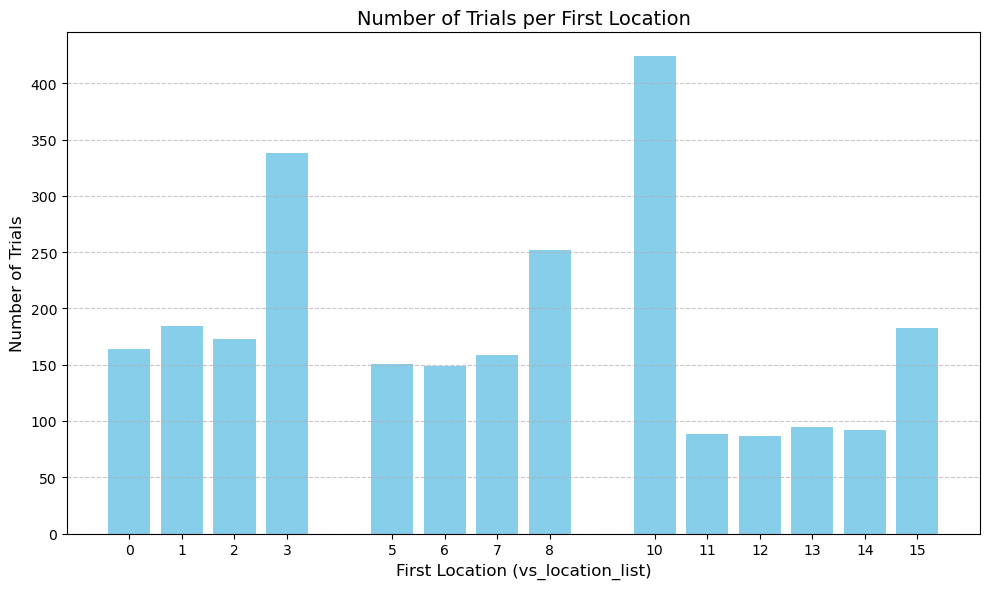

In [58]:
# Convert to DataFrame
#df = pd.DataFrame(data)
# Count the frequency of each First_Location
location_counts = vs_grouped['first_location'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(location_counts.index, location_counts.values, color='skyblue')
plt.xlabel('First Location (vs_location_list)', fontsize=12)
plt.ylabel('Number of Trials', fontsize=12)
plt.title('Number of Trials per First Location', fontsize=14)
plt.xticks(location_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

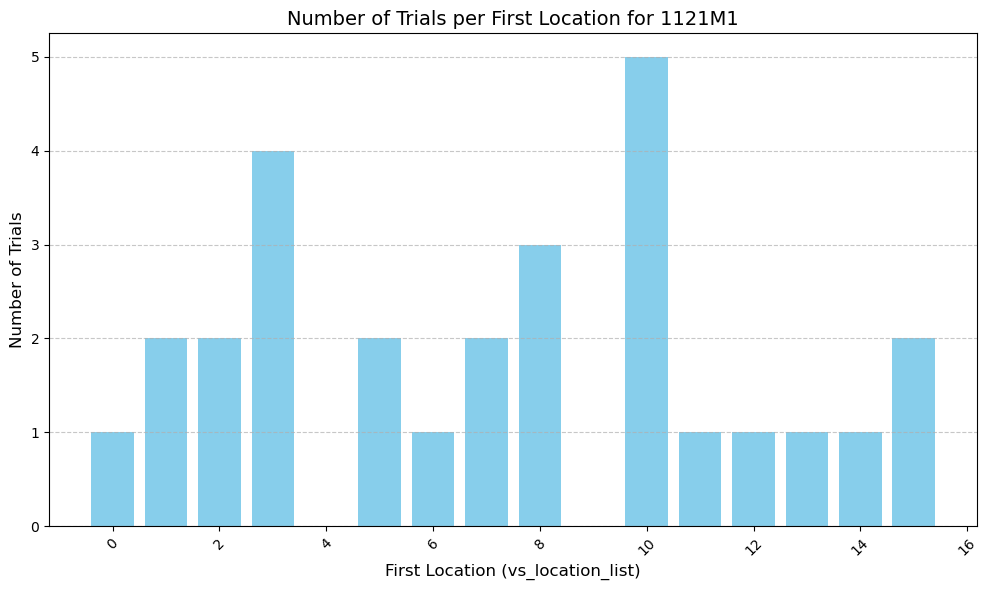

In [59]:
# Filter for one participant
subject = '1121M1'  # Change this to the actual ID
df_person = vs_grouped[vs_grouped['subject'] == subject]

# Count the frequency of each First_Location for that person
location_counts = df_person['first_location'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(location_counts.index, location_counts.values, color='skyblue')
plt.xlabel('First Location (vs_location_list)', fontsize=12)
plt.ylabel('Number of Trials', fontsize=12)
plt.title(f'Number of Trials per First Location for {subject}', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

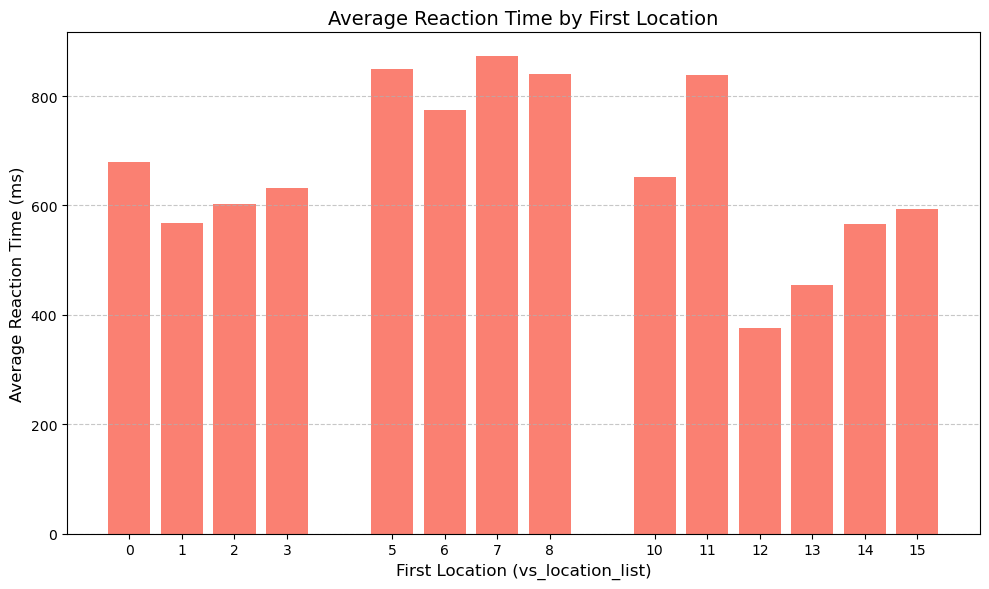

In [60]:
# Filter out invalid RTs (e.g., -1) and ensure we only consider valid trials
valid_rt_df = vs_grouped[(vs_grouped['rt'] > 0)]

# Group by First_Location and compute mean reaction time
avg_rt_per_location = valid_rt_df.groupby('first_location')['rt'].mean().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(avg_rt_per_location.index, avg_rt_per_location.values, color='salmon')
plt.xlabel('First Location (vs_location_list)', fontsize=12)
plt.ylabel('Average Reaction Time (ms)', fontsize=12)
plt.title('Average Reaction Time by First Location', fontsize=14)
plt.xticks(avg_rt_per_location.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

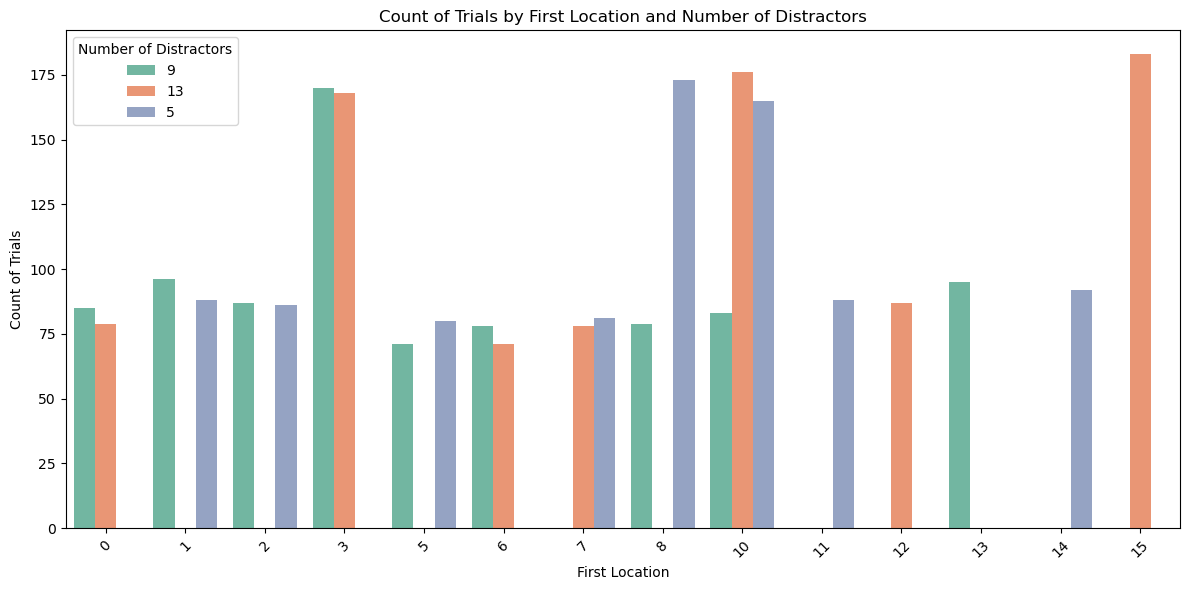

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
condition_map = {'Five': 5, 'Nine': 9, 'Thirteen': 13}
vs_grouped['Num_Distractors'] = vs_grouped['condition'].map(condition_map)
# Ensure Num_Distractors is categorical (as string)
vs_grouped['Num_Distractors'] = vs_grouped['Num_Distractors'].astype(str)

# Create a count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=vs_grouped, x='first_location', hue='Num_Distractors', palette='Set2')

plt.title('Count of Trials by First Location and Number of Distractors')
plt.xlabel('First Location')
plt.ylabel('Count of Trials')
plt.legend(title='Number of Distractors')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

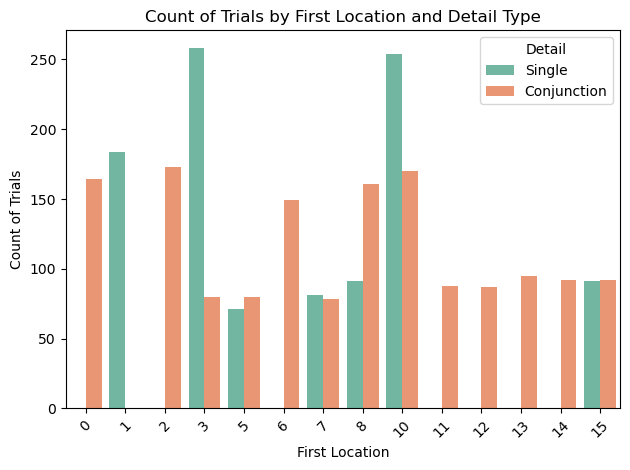

In [62]:
# Ensure 'detail' is treated as a string for the hue
vs_grouped['detail'] = vs_grouped['detail'].astype(str)

# Create count plot
sns.countplot(data=vs_grouped, x='first_location', hue='detail', palette='Set2')

# Plot formatting
plt.title('Count of Trials by First Location and Detail Type')
plt.xlabel('First Location')
plt.ylabel('Count of Trials')
plt.legend(title='Detail')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
import pandas as pd
from scipy.stats import f_oneway

# Group reaction times by First_Location
groups = [group['rt'].dropna().values for name, group in vs_grouped.groupby('first_location')]

# One-way ANOVA
f_stat, p_val = f_oneway(*groups)

print("F-statistic:", f_stat)
print("p-value:", p_val)

F-statistic: 6.305081874461055
p-value: 7.669412885833099e-12


In [66]:
def get_quadrant(location):
    if location in [1, 2, 3]:
        return 'top_right'
    elif location in [4, 5, 6]:
        return 'bottom_right'
    elif location in [7, 8, 9]:
        return 'bottom_left'
    elif location in [10, 11, 0]:
        return 'top_left'
    elif location in [12, 13, 14, 15, 16]:
        return 'close'
    else:
        return 'unknown'  # fallback for unexpected values

# Apply the function to the DataFrame
vs_grouped['quadrant'] = vs_grouped['first_location'].apply(get_quadrant)

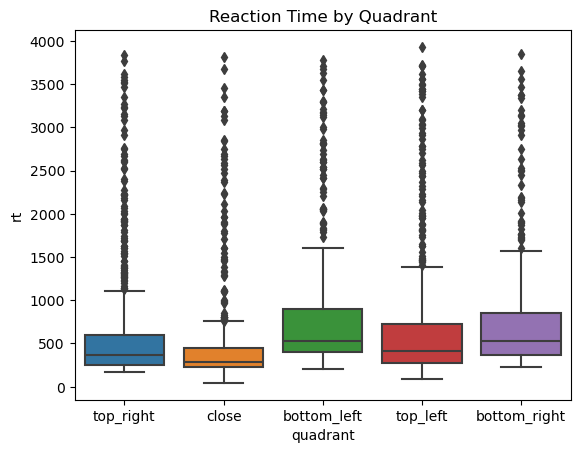

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='quadrant', y='rt', data=vs_grouped)
plt.title("Reaction Time by Quadrant")
plt.show()

In [68]:
import scipy.stats as stats

# Prepare groups
groups = [group['rt'].values for name, group in vs_grouped.groupby('quadrant')]

# Run one-way ANOVA
f_stat, p_value = stats.f_oneway(*groups)
print("ANOVA results: F =", f_stat, ", p =", p_value)

ANOVA results: F = 16.912507846094023 , p = 1.0800201128538575e-13


In [69]:
# Run Kruskal-Wallis H-test (non-parametric alternative to ANOVA)
h_stat, p_kw = stats.kruskal(*groups)
print("Kruskal-Wallis results: H =", h_stat, ", p =", p_kw)

Kruskal-Wallis results: H = 244.14805813912002 , p = 1.1860123454238839e-51


In [73]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
vs_grouped['rt'] = pd.to_numeric(vs_grouped['rt'], errors='coerce')  # convert or set to NaN
vs_grouped = vs_grouped.dropna(subset=['rt'])
# Tukey HSD
tukey = pairwise_tukeyhsd(endog=vs_grouped['rt'], groups=vs_grouped['quadrant'], alpha=0.05)
print(tukey)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1       group2     meandiff p-adj    lower     upper   reject
---------------------------------------------------------------------
 bottom_left bottom_right  -41.0947 0.9385 -186.2608  104.0714  False
 bottom_left        close -335.5541    0.0  -465.509 -205.5992   True
 bottom_left     top_left -170.7756 0.0009 -290.3484  -51.2028   True
 bottom_left    top_right -245.3589    0.0 -364.3121 -126.4057   True
bottom_right        close -294.4594    0.0 -436.5094 -152.4095   True
bottom_right     top_left -129.6809 0.0589  -262.299    2.9372  False
bottom_right    top_right -204.2642 0.0002 -336.3239  -72.2045   True
       close     top_left  164.7785  0.001   49.0087  280.5484   True
       close    top_right   90.1953 0.2041  -24.9345   205.325  False
    top_left    top_right  -74.5833 0.2803 -177.8511   28.6845  False
---------------------------------------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


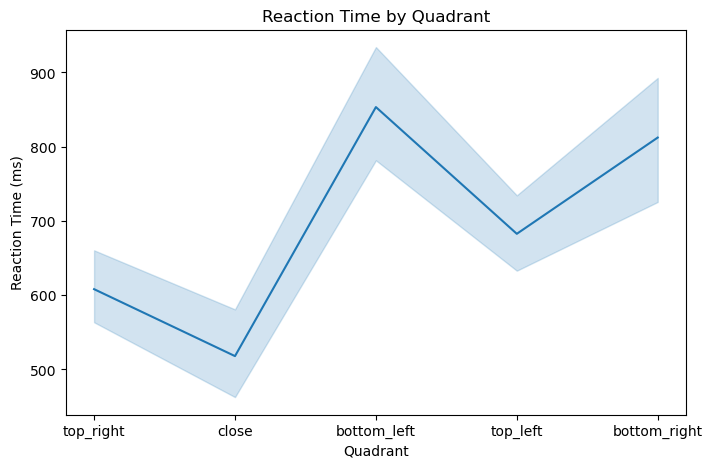

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.lineplot(x='quadrant', y='rt', data=vs_grouped)#, order=['top_right', 'bottom_right', 'bottom_left', 'top_left', 'close'])
plt.title('Reaction Time by Quadrant')
plt.ylabel('Reaction Time (ms)')
plt.xlabel('Quadrant')
plt.show()

### Anova to test differences 

#### Assumption of normality

In [75]:
pg.normality(data=vs_grouped, dv='rt', group='condition')

,W,pval,normal
condition,,,
Nine,0.621399,1.994803e-39,False
Thirteen,0.615162,1.281658e-39,False
Five,0.715846,1.168406e-35,False


In [76]:
pg.normality(data=vs_grouped, dv='rt', group='detail')

,W,pval,normal
detail,,,
Single,0.641019,6.744450e-42,False
Conjunction,0.661032,0.000000e+00,False


In [77]:
# Perform normality tests for each group and condition and detauk
results=[]

for group in vs_grouped['diagnosis_group'].unique():
    for condition in vs_grouped['condition'].unique():
        
        subset = vs_grouped[(vs_grouped['diagnosis_group'] == group) & (vs_grouped['condition'] == condition)]
        test_result = pg.normality(subset['rt'], method='shapiro')
        results.append({
            'diagnosis_group': group,
            'condition': condition,
            'p-value': test_result['pval'].values[0],
            'Normal': 'Yes' if test_result['pval'].values[0] > 0.05 else 'No'
        })

results_df = pd.DataFrame(results)


results_df

,diagnosis_group,condition,p-value,Normal
0,control,Nine,8.620288e-34,No
1,control,Thirteen,3.040373e-33,No
2,control,Five,5.235106e-30,No
3,asd,Nine,6.969700e-19,No
4,asd,Thirteen,3.995125e-19,No
5,asd,Five,1.615400e-16,No
6,adhd,Nine,1.361638e-14,No
7,adhd,Thirteen,1.435879e-16,No
8,adhd,Five,5.642767e-14,No


In [78]:
# Store results in a list
results = []

# Iterate over unique (asd, condition, DETAIL) combinations
for group in vs_grouped['diagnosis_group'].unique():
    for condition in vs_grouped['condition'].unique():
        for detail in vs_grouped['detail'].unique():
            
            # Subset the data
            subset = vs_grouped[
                (vs_grouped['diagnosis_group'] == group) & 
                (vs_grouped['condition'] == condition) & 
                (vs_grouped['detail'] == detail)
            ]
            
            # Ensure the subset is not empty
            if len(subset) > 2:  # Shapiro-Wilk requires at least 3 samples
                test_result = pg.normality(subset['rt'], method='shapiro')
                results.append({
                    'diagnosis_group': group,
                    'condition': condition,
                    'detail': detail,
                    'p-value': test_result['pval'].values[0],
                    'Normal': 'Yes' if test_result['pval'].values[0] > 0.05 else 'No'
                })

# Convert list of results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)
results_df

   diagnosis_group condition       detail       p-value Normal
0          control      Nine       Single  2.163859e-23     No
1          control      Nine  Conjunction  3.248004e-26     No
2          control  Thirteen       Single  9.361094e-24     No
3          control  Thirteen  Conjunction  2.705521e-25     No
4          control      Five       Single  9.353045e-19     No
5          control      Five  Conjunction  2.769360e-24     No
6              asd      Nine       Single  2.472597e-12     No
7              asd      Nine  Conjunction  4.187646e-14     No
8              asd  Thirteen       Single  8.039709e-13     No
9              asd  Thirteen  Conjunction  3.803390e-14     No
10             asd      Five       Single  3.367297e-10     No
11             asd      Five  Conjunction  1.635251e-12     No
12            adhd      Nine       Single  2.537755e-08     No
13            adhd      Nine  Conjunction  9.811421e-12     No
14            adhd  Thirteen       Single  1.032613e-11

,diagnosis_group,condition,detail,p-value,Normal
0,control,Nine,Single,2.163859e-23,No
1,control,Nine,Conjunction,3.248004e-26,No
2,control,Thirteen,Single,9.361094e-24,No
3,control,Thirteen,Conjunction,2.705521e-25,No
4,control,Five,Single,9.353045e-19,No
5,control,Five,Conjunction,2.769360e-24,No
6,asd,Nine,Single,2.472597e-12,No
7,asd,Nine,Conjunction,4.187646e-14,No
8,asd,Thirteen,Single,8.039709e-13,No
9,asd,Thirteen,Conjunction,3.803390e-14,No


#### Assumption of normality transformations

In [80]:
#Applied various trasnformations
vs_grouped["log_rt"]=np.log(vs_grouped.rt)
vs_grouped["sqrt_rt"]=np.sqrt(vs_grouped.rt)
vs_grouped["reciprocal_rt"] = boxcox(vs_grouped.rt,-0.5)
vs_grouped["boxcox_rt"] = boxcox(vs_grouped.rt,0.00001)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

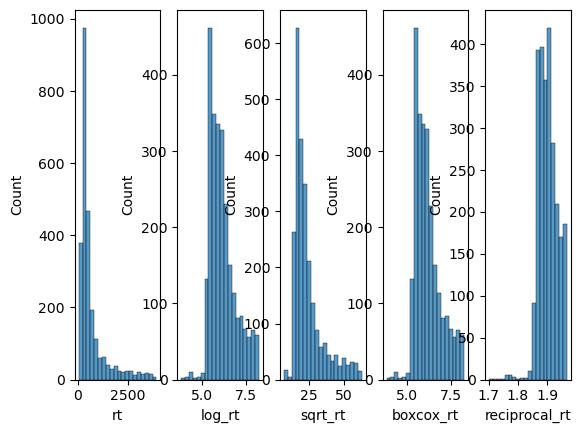

Figure saved at: C:/Users/audrey-annebeaudry/Desktop/Q1K_results/figures/rt_transformations_09_03_2025.png


In [81]:
fig, axs = plt.subplots(ncols=5)
sns.histplot(vs_grouped.rt,edgecolor='black', bins=20, ax=axs[0])
sns.histplot(vs_grouped.log_rt,edgecolor='black', bins=20, ax=axs[1])
sns.histplot(vs_grouped.sqrt_rt,edgecolor='black', bins=20, ax=axs[2])
sns.histplot(vs_grouped.boxcox_rt,edgecolor='black', bins=20, ax=axs[3])
sns.histplot(vs_grouped.reciprocal_rt,edgecolor='black', bins=20, ax=axs[4])
# Save the figure in doc folder and then doc 


# Define the correct save path
save_path = "C:/Users/audrey-annebeaudry/Desktop/Q1K_results/figures"

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Save the figure
fig_path = f"{save_path}/rt_transformations_{date}.png"
plt.savefig(fig_path)

# Show the figure
plt.show()

# Add the figure to a Word document
doc = docx.Document()
doc.add_heading('Transformations figure', level=4)

# Insert the image into the document
doc.add_picture(fig_path, width=docx.shared.Inches(6), height=docx.shared.Inches(4))

print(f"Figure saved at: {fig_path}")


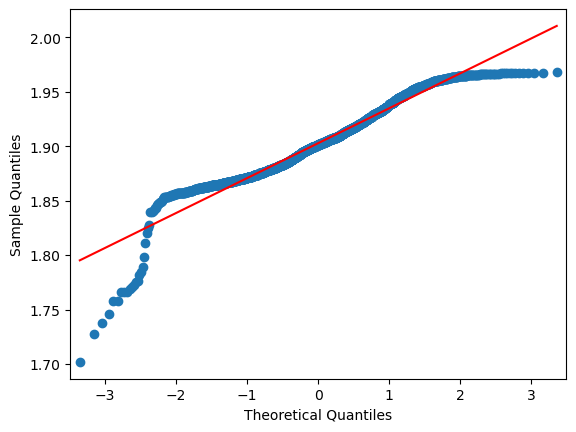

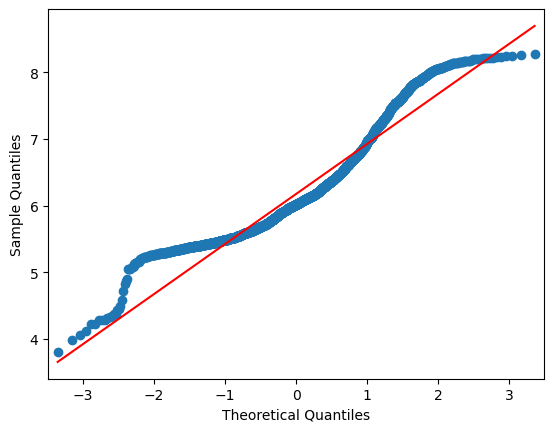

In [82]:
fig = sm.qqplot(vs_grouped.reciprocal_rt, line='s')

fig = sm.qqplot(vs_grouped.log_rt, line='s')

plt.show()

In [83]:
pg.normality(data=vs_grouped, dv='reciprocal_rt', group='condition')

,W,pval,normal
condition,,,
Nine,0.970173,4.053488e-12,False
Thirteen,0.926696,7.714623e-20,False
Five,0.964051,1.215132e-13,False


In [84]:
pg.normality(data=vs_grouped, dv='reciprocal_rt', group='detail')

,W,pval,normal
detail,,,
Single,0.944818,3.728415e-19,False
Conjunction,0.946234,4.934173e-23,False


In [85]:
# Perform normality tests for each group and condition
results=[]

for group in vs_grouped['diagnosis_group'].unique():
    for condition in vs_grouped['condition'].unique():
        subset = vs_grouped[(vs_grouped['diagnosis_group'] == group) & (vs_grouped['condition'] == condition)]
        test_result = pg.normality(subset['sqrt_rt'], method='shapiro')
        results.append({
            'diagnosis_group': group,
            'condition': condition,
            'p-value': test_result['pval'].values[0],
            'Normal': 'Yes' if test_result['pval'].values[0] > 0.05 else 'No'
        })

results_df = pd.DataFrame(results)


results_df

,diagnosis_group,condition,p-value,Normal
0,control,Nine,9.913133e-28,No
1,control,Thirteen,4.523960e-26,No
2,control,Five,2.802819e-24,No
3,asd,Nine,1.447836e-14,No
4,asd,Thirteen,4.512333e-14,No
5,asd,Five,4.346550e-12,No
6,adhd,Nine,1.922162e-11,No
7,adhd,Thirteen,1.650313e-12,No
8,adhd,Five,4.571029e-10,No


In [86]:
# Store results in a list
results = []

# Iterate over unique (asd, condition, DETAIL) combinations
for group in vs_grouped['diagnosis_group'].unique():
    for condition in vs_grouped['condition'].unique():
        for detail in vs_grouped['detail'].unique():
            
            # Subset the data
            subset = vs_grouped[
                (vs_grouped['diagnosis_group'] == group) & 
                (vs_grouped['condition'] == condition) & 
                (vs_grouped['detail'] == detail)
            ]
            
            # Ensure the subset has enough data for normality testing
            if len(subset) > 2:  # Shapiro-Wilk requires at least 3 observations
                test_result = pg.normality(subset['reciprocal_rt'], method='shapiro')
                results.append({
                    'diagnosis_group': group,
                    'condition': condition,
                    'detail': detail,
                    'p-value': test_result['pval'].values[0],
                    'Normal': 'Yes' if test_result['pval'].values[0] > 0.05 else 'No'
                })
            else:
                results.append({
                    'diagnosis_group': group,
                    'condition': condition,
                    'detail': detail,
                    'p-value': None,
                    'Normal': 'Insufficient Data'
                })

# Convert list of results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

   diagnosis_group condition       detail       p-value Normal
0          control      Nine       Single  8.204204e-07     No
1          control      Nine  Conjunction  6.000918e-05     No
2          control  Thirteen       Single  4.422677e-12     No
3          control  Thirteen  Conjunction  1.451368e-16     No
4          control      Five       Single  1.693253e-06     No
5          control      Five  Conjunction  6.728719e-09     No
6              asd      Nine       Single  9.126163e-04     No
7              asd      Nine  Conjunction  1.083226e-03     No
8              asd  Thirteen       Single  2.837230e-05     No
9              asd  Thirteen  Conjunction  8.117523e-08     No
10             asd      Five       Single  2.514265e-02     No
11             asd      Five  Conjunction  5.001426e-04     No
12            adhd      Nine       Single  2.793484e-02     No
13            adhd      Nine  Conjunction  1.126084e-02     No
14            adhd  Thirteen       Single  1.541004e-03

#### Assumption of sphericity (Mauchly’s test)

In [87]:
pg.sphericity(data=vs_grouped, dv='reciprocal_rt', subject='subject', within='condition', method='mauchly')

/opt/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


SpherResults(spher=True, W=inf, chi2=-inf, dof=2, pval=1.0)

In [88]:
# Add to doc 
if pg.sphericity(data=vs_grouped, dv='reciprocal_rt', subject='subject', within='condition')[-1] < 0.05:
    p16= "Assumption of sphericity is violated : " + str(pg.sphericity(data=vs_grouped, dv='reciprocal_rt', subject='subject', within='condition')[-1].round(4))
    print(p16)
    # Add to doc 
    doc.add_paragraph(p16, style='List Bullet')
else:
    print("Assumption of sphericity is met")
    doc.add_paragraph("Assumption of sphericity is met", style='List Bullet')


Assumption of sphericity is met


/opt/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


#### Assumptions of Levenes test

In [90]:
# Calculte levels test assumptions 
pg.homoscedasticity(data=vs_grouped, dv='reciprocal_rt', group='diagnosis_group', method='levene')

,W,pval,equal_var
levene,2.061261,0.127507,True


In [91]:
if pg.homoscedasticity(data=vs_grouped, dv='reciprocal_rt', group='diagnosis_group', method='levene')["pval"].values[0] < 0.05:
    p17= "Assumption of homoscedasticity is violated" + str(pg.homoscedasticity(data=vs_grouped, dv='reciprocal_rt', group='diagnosis_group', method='levene')[-1])
    print(p17)
    # Add to doc 
    doc.add_paragraph(p17, style='List Bullet')
else: 
    print("Assumption of homoscedastic is met")
    doc.add_paragraph("Assumption of homoscedastic is met", style='List Bullet')

Assumption of homoscedastic is met


In [92]:
# Run the repeated measures ANOVA for condition
res_condition = pg.rm_anova(dv="reciprocal_rt", within="condition", subject="subject", data=vs_grouped).round(4)

# Show the results
res_condition

/opt/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,condition,2,206,19.6977,0.0,0.0447,0.9387


In [93]:
# Run the repeated measures ANOVA for condition
res_condition = pg.rm_anova(dv="reciprocal_rt", within="detail", subject="subject", data=vs_grouped)

# Show the results
res_condition

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,detail,1,103,3.081915,0.08214,0.004286,1.0


In [94]:
anova_results = pg.rm_anova(
    data=vs_grouped, 
    dv="reciprocal_rt", 
    subject="subject",
    within=["condition", "detail"], 
    detailed=True
)

anova_results

/opt/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/opt/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,condition,0.011152,2,194,0.005576,29.165263,8.427485e-12,1.046154e-11,0.042896,0.990071
1,detail,0.001207,1,97,0.001207,6.454711,1.265242e-02,1.265242e-02,0.004827,1.000000
2,condition * detail,0.001977,2,194,0.000989,6.070891,2.771171e-03,2.937785e-03,0.007884,0.982937


In [95]:
#### One-way measures ANOVA for detail
res = pg.mixed_anova(dv="reciprocal_rt", within="detail", between="diagnosis_group", subject="subject", data=vs_grouped).round(4)
res

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,diagnosis_group,0.0009,2,101,0.0005,0.7853,0.4588,0.0153,NaN
1,detail,0.0003,1,101,0.0003,3.0731,0.0826,0.0295,1.0
2,Interaction,0.0002,2,101,0.0001,0.8529,0.4292,0.0166,NaN


In [96]:
### One-way measures ANOVA for detail
res = pg.mixed_anova(dv="reciprocal_rt", within="condition", between="diagnosis_group", subject="subject", data=vs_grouped).round(4)
res

/opt/anaconda3/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,diagnosis_group,0.0020,2,101,0.0010,1.1473,0.3216,0.0222,NaN
1,condition,0.0055,2,202,0.0028,19.9256,0.0000,0.1648,0.9387
2,Interaction,0.0009,4,202,0.0002,1.5958,0.1768,0.0306,NaN


In [97]:
post_hocs = pg.pairwise_tests(dv='reciprocal_rt', within=['condition', 'detail'],
                               subject='subject', between = 'diagnosis_group', padjust='fdr_bh', data=vs_grouped).round(5)
post_hocs

,Contrast,condition,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,condition,-,Five,Nine,True,True,4.80941,97.0,two-sided,0.00001,0.00001,fdr_bh,2760.467,0.33934
1,condition,-,Five,Thirteen,True,True,7.52744,97.0,two-sided,0.00000,0.00000,fdr_bh,3.294e+08,0.56288
2,condition,-,Nine,Thirteen,True,True,2.89195,97.0,two-sided,0.00473,0.00473,fdr_bh,5.555,0.23274
3,detail,-,Conjunction,Single,True,True,2.54061,97.0,two-sided,0.01265,NaN,NaN,2.341,0.16223
4,condition * detail,Five,Conjunction,Single,True,True,-1.41561,97.0,two-sided,0.16009,0.16009,fdr_bh,0.293,-0.10478
5,condition * detail,Nine,Conjunction,Single,True,True,2.36469,97.0,two-sided,0.02004,0.03005,fdr_bh,1.576,0.21982
6,condition * detail,Thirteen,Conjunction,Single,True,True,3.00284,97.0,two-sided,0.00340,0.01021,fdr_bh,7.441,0.30412


In [98]:
## Group control and detail

vs_grouped['cond_det'] = vs_grouped['condition']+ '_' +vs_grouped['detail']

In [99]:
vs_grouped['diagnosis_group'] = vs_grouped['diagnosis_group'].astype('category')
vs_grouped['diagnosis_group'].isna().sum()

0

In [100]:
post_hocs = pg.pairwise_tests(dv='reciprocal_rt', within='cond_det',
                               subject='subject', between='diagnosis_group', padjust='fdr_bh', data=vs_grouped).round(5)
post_hocs

,Contrast,cond_det,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,cond_det,-,Five_Conjunction,Five_Single,True,True,-1.41561,97.00000,two-sided,0.16009,0.17153,fdr_bh,0.293,-0.10478
1,cond_det,-,Five_Conjunction,Nine_Conjunction,True,True,1.89189,97.00000,two-sided,0.06149,0.07686,fdr_bh,0.618,0.14938
2,cond_det,-,Five_Conjunction,Nine_Single,True,True,4.26517,97.00000,two-sided,0.00005,0.00012,fdr_bh,377.782,0.37754
3,cond_det,-,Five_Conjunction,Thirteen_Conjunction,True,True,3.20656,97.00000,two-sided,0.00182,0.00390,fdr_bh,13.038,0.30908
4,cond_det,-,Five_Conjunction,Thirteen_Single,True,True,7.06609,97.00000,two-sided,0.00000,0.00000,fdr_bh,3.913e+07,0.62019
5,cond_det,-,Five_Single,Nine_Conjunction,True,True,2.79813,97.00000,two-sided,0.00620,0.01009,fdr_bh,4.369,0.24502
6,cond_det,-,Five_Single,Nine_Single,True,True,4.97420,97.00000,two-sided,0.00000,0.00001,fdr_bh,5192.815,0.46361
7,cond_det,-,Five_Single,Thirteen_Conjunction,True,True,4.26647,97.00000,two-sided,0.00005,0.00012,fdr_bh,379.501,0.39696
8,cond_det,-,Five_Single,Thirteen_Single,True,True,7.71659,97.00000,two-sided,0.00000,0.00000,fdr_bh,7.977e+08,0.69313
9,cond_det,-,Nine_Conjunction,Nine_Single,True,True,2.36469,97.00000,two-sided,0.02004,0.02732,fdr_bh,1.576,0.21982


### Linear model analysis 

In [104]:
vs_dis=vs_grouped[["subject","cond_det", "condition", "detail", "reciprocal_rt", "rt", "vs_location_list", "first_location", "quadrant"]]

In [105]:
vs_dis=vs_dis.groupby(["subject","cond_det", "condition", "detail", "vs_location_list", "first_location", "quadrant"]).mean().reset_index()

In [106]:
vs_grouped= vs_dis
vs_grouped #.dropna(inplace=True)

# check for na 
vs_grouped[vs_grouped.isna().any(axis=1)]

,subject,cond_det,condition,detail,vs_location_list,first_location,quadrant,reciprocal_rt,rt


In [107]:
## Add demographic back to vs_grouped
vs_grouped=pd.merge(vs_grouped, outlier_demo, on="subject", how="inner")

In [108]:
vs_grouped


,subject,cond_det,condition,detail,vs_location_list,first_location,quadrant,reciprocal_rt,rt,diagnosis_group,sex,age,n_trials,site,age_group
0,0042P,Five_Conjunction,Five,Conjunction,"(10, 15, 0, 13, 14)",10,top_left,1.881322,284.0,control,female,30.215656,28,mni,adult
1,0042P,Five_Conjunction,Five,Conjunction,"(11, 5, 8, 6, 0)",11,top_left,1.892324,345.0,control,female,30.215656,28,mni,adult
2,0042P,Five_Conjunction,Five,Conjunction,"(14, 1, 5, 3, 7)",14,close,1.895315,365.0,control,female,30.215656,28,mni,adult
3,0042P,Five_Conjunction,Five,Conjunction,"(2, 0, 13, 7, 8)",2,top_right,1.906239,455.0,control,female,30.215656,28,mni,adult
4,0042P,Five_Conjunction,Five,Conjunction,"(5, 9, 4, 15, 6)",5,bottom_right,1.900249,402.0,control,female,30.215656,28,mni,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,1147S2,Thirteen_Conjunction,Thirteen,Conjunction,"(7, 16, 15, 1, 2, 13, 11, 5, 6, 4, 12, 10, 3)",7,bottom_left,1.896720,375.0,control,female,22.787714,29,hsj,adult
2535,1147S2,Thirteen_Single,Thirteen,Single,"(10, 4, 9, 7, 13, 2, 5, 3, 16, 11, 6, 8, 1)",10,top_left,1.886408,310.0,control,female,22.787714,29,hsj,adult
2536,1147S2,Thirteen_Single,Thirteen,Single,"(15, 10, 14, 4, 11, 16, 3, 7, 13, 1, 2, 8, 6)",15,close,1.865160,220.0,control,female,22.787714,29,hsj,adult
2537,1147S2,Thirteen_Single,Thirteen,Single,"(3, 13, 2, 4, 10, 11, 1, 5, 14, 6, 12, 8, 16)",3,top_right,1.922733,670.0,control,female,22.787714,29,hsj,adult


# Mixed effects linear modelling

In [110]:
import statsmodels.formula.api as smf


## FUNCTIONS for linear models 

In [111]:
def coefplot_gap(results, multiple_models=False, fig_name=None):
    '''
    Creates a coefficient plot with confidence intervals.
   
    Parameters:
    results : statsmodels results object or DataFrame
        If multiple_models=False: statsmodels results object
        If multiple_models=True: DataFrame with columns: index, model, Coef., [0.025, P>|z|
    multiple_models : bool, default False
        Whether to create a plot for multiple models or single model
   
    Returns:
        matplotlib plot
    '''
    # Create/process dataframe based on input type
    if not multiple_models:
        coef_df = pd.DataFrame(results.summary().tables[1]).reset_index()
    else:
        coef_df = results.copy()
   
    # Drop unwanted rows
    coef_df = coef_df.loc[coef_df["index"].isin(['Group Var', 'Intercept']) == False]
   
    # Convert numeric columns to float
    coef_df['Coef.'] = coef_df['Coef.'].astype(float)
    coef_df['[0.025'] = coef_df['[0.025'].astype(float)
    coef_df['P>|z|'] = coef_df['P>|z|'].astype(float)
   
    # Calculate errors
    coef_df['errors'] = coef_df['Coef.'] - coef_df['[0.025']
   
    # Create significance indicators - make them consistent between both cases
    if multiple_models:
        coef_df['Significance'] = coef_df['P>|z|'].apply(
            lambda x: 'Significant' if x < 0.05 else 'Not Significant'
        )
    else:
        # Changed to match the multiple models case
        coef_df['Significance'] = coef_df['P>|z|'].apply(
            lambda x: 'Significant' if x < 0.05 else 'Not Significant'
        )
   
    # Clean up Treatment variable names
    for var_name in coef_df['index'].unique():
        if "Treatment" in var_name:
            if ":" in var_name:
                var1 = var_name.split("[",1)[1].split("]")[0]
                var2 = var_name.split("[", 2)[-1]
                new_var_name = var1 + ":" + var2
            else:
                new_var_name = var_name.split("[", 1)[1].split("]")[0]
            coef_df['index'] = coef_df['index'].replace(var_name, new_var_name)
   
    # Create plot
    fig, ax = plt.subplots(figsize=(18, 10))
   
    # Define consistent marker styles
    marker_styles = {'Significant': 'X', 'Not Significant': 'o'}
   

    if multiple_models:
        # Get models and calculate positions
        models = coef_df['model'].unique()
        variables = coef_df['index'].unique()
        n_models = len(models)
        space_between = 2.5
        model_spacing = 1.0
       
        # Create position mapping
        positions = {}
        # Sort variables by their average coefficient value (lowest to highest)
        var_means = coef_df.groupby('index')['Coef.'].mean().sort_values()
        sorted_vars = var_means.index
       
        for i, var in enumerate(sorted_vars):
            base_pos = i * (n_models + space_between)
            for j, model in enumerate(models):
                positions[(var, model)] = base_pos + (j * model_spacing)
       
        # Add plot positions
        coef_df['plot_position'] = coef_df.apply(
            lambda row: positions[(row['index'], row['model'])],
            axis=1
        )
       
        # Set up colors for multiple models
        model_palette = sns.color_palette("husl", n_colors=len(models))
        model_colors = dict(zip(models, model_palette))
       
        # Plot error bars
        for model in models:
            model_data = coef_df[coef_df['model'] == model]
            plt.errorbar(x=model_data['Coef.'],
                        y=model_data['plot_position'],
                        xerr=model_data['errors'],
                        color=model_colors[model],
                        capsize=3,
                        fmt='none',
                        alpha=0.7,
                        zorder=1)
       
        # Plot points
        g = sns.scatterplot(data=coef_df,
                           x='Coef.',
                           y='plot_position',
                           hue='model',
                           style='Significance',
                           markers=marker_styles,
                           palette=model_colors,
                           s=200,
                           zorder=3,
                           ax=ax)
       
        # Set y-ticks
        tick_positions = []
        for i, var in enumerate(sorted_vars):
            base_pos = i * (n_models + space_between)
            middle_pos = base_pos + ((n_models - 1) * model_spacing) / 2
            tick_positions.append(middle_pos)
       
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(sorted_vars)
       
        # Create legends
        g.legend_.remove()
       
        # Model legend
        model_legend = ax.legend(
            title='Models',
            handles=[plt.Line2D([], [], marker='o', color=color, linestyle='None',
                               markersize=10, label=model)
                    for model, color in model_colors.items()],
            bbox_to_anchor=(1.02, 1),
            loc='upper left'
        )
       
        # Significance legend
        significance_handles = [
            plt.Line2D([], [], marker='X', color='gray', linestyle='None',
                      markersize=10, label='Significant'),
            plt.Line2D([], [], marker='o', color='gray', linestyle='None',
                      markersize=10, label='Not Significant')
        ]
       
        ax.add_artist(model_legend)
        ax.legend(handles=significance_handles,
                 title='Significance',
                 bbox_to_anchor=(1.02, 0.6),
                 loc='upper left')
       
    else:
        # Sort the dataframe by coefficient values (lowest to highest)
        coef_df = coef_df.sort_values(by='Coef.', ascending=False)
       
        # Single model plot
        palette = sns.color_palette("Set1")
        color_map = {'Significant': palette[0], 'Not Significant': palette[1]}
       
        # Error bars
        for idx, row in coef_df.iterrows():
            error_color = color_map[row['Significance']]
            plt.errorbar(x=row['Coef.'],
                        y=row['index'],
                        xerr=row['errors'],
                        color=error_color,
                        capsize=3,
                        fmt='none',
                        zorder=1)
       
        # Scatter plot with consistent markers
        g = sns.scatterplot(y='index',
                           x='Coef.',
                           style='Significance',
                           hue='Significance',
                           markers=marker_styles,
                           palette=color_map,
                           s=200,
                           data=coef_df,
                           zorder=3,
                           ax=ax)
   
    # Common plot elements
    ax.axvline(x=0, linestyle='--', color='red', linewidth=1)
   
    # Set title & labels
    title = 'Coefficients Across Models w/ 95% Confidence Intervals' if multiple_models else 'Coefficients of Features w/ 95% Confidence Intervals'
    plt.title(title, fontsize=30)
    ax.set_ylabel('Variables' if multiple_models else 'Coefficients', fontsize=22)
    ax.set_xlabel('Coefficient Value' if multiple_models else '', fontsize=22)
   
    # Set x-axis limits
    ax.set_xlim(coef_df['Coef.'].min() - max(coef_df['errors']),
                coef_df['Coef.'].max() + max(coef_df['errors']))
   
    plt.tight_layout()

        # Add to the document
   
    if multiple_models:
        doc.add_paragraph('Multiple models coefficient plot', style='List Bullet')
    else:

         doc.add_paragraph('Mixed effects model results', style='List Bullet')

    
    # Save the plot
    #plt.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/Q1K_neurosubs_2025/results/gap/figures/mixed_effects_model_{fig_name}_{date}.png")

    plt.show()
    return plt.show()

In [112]:
def coefplot_gap(results, multiple_models=False, fig_name=None):
    '''
    Creates a coefficient plot with confidence intervals.
   
    Parameters:
    results : statsmodels results object or DataFrame
        If multiple_models=False: statsmodels results object
        If multiple_models=True: DataFrame with columns: index, model, Coef., [0.025, P>|z|
    multiple_models : bool, default False
        Whether to create a plot for multiple models or single model
   
    Returns:
        matplotlib plot
    '''
    # Create/process dataframe based on input type
    if not multiple_models:
        coef_df = pd.DataFrame(results.summary().tables[1]).reset_index()
    else:
        coef_df = results.copy()
   
    # Drop unwanted rows
    coef_df = coef_df.loc[coef_df["index"].isin(['Group Var', 'Intercept']) == False]
   
    # Convert numeric columns to float
    coef_df['Coef.'] = coef_df['Coef.'].astype(float)
    coef_df['[0.025'] = coef_df['[0.025'].astype(float)
    coef_df['P>|z|'] = coef_df['P>|z|'].astype(float)
   
    # Calculate errors
    coef_df['errors'] = coef_df['Coef.'] - coef_df['[0.025']
   
    # Create significance indicators - make them consistent between both cases
    if multiple_models:
        coef_df['Significance'] = coef_df['P>|z|'].apply(
            lambda x: 'Significant' if x < 0.05 else 'Not Significant'
        )
    else:
        # Changed to match the multiple models case
        coef_df['Significance'] = coef_df['P>|z|'].apply(
            lambda x: 'Significant' if x < 0.05 else 'Not Significant'
        )
   
    # Clean up Treatment variable names
    for var_name in coef_df['index'].unique():
        if "Treatment" in var_name:
            if ":" in var_name:
                var1 = var_name.split("[",1)[1].split("]")[0]
                var2 = var_name.split("[", 2)[-1]
                new_var_name = var1 + ":" + var2
            else:
                new_var_name = var_name.split("[", 1)[1].split("]")[0]
            coef_df['index'] = coef_df['index'].replace(var_name, new_var_name)
   
    # Create plot
    fig, ax = plt.subplots(figsize=(18, 10))
   
    # Define consistent marker styles
    marker_styles = {'Significant': 'X', 'Not Significant': 'o'}
   

    if multiple_models:
        # Get models and calculate positions
        models = coef_df['model'].unique()
        variables = coef_df['index'].unique()
        n_models = len(models)
        space_between = 2.5
        model_spacing = 1.0
       
        # Create position mapping
        positions = {}
        # Sort variables by their average coefficient value (lowest to highest)
        var_means = coef_df.groupby('index')['Coef.'].mean().sort_values()
        sorted_vars = var_means.index
       
        for i, var in enumerate(sorted_vars):
            base_pos = i * (n_models + space_between)
            for j, model in enumerate(models):
                positions[(var, model)] = base_pos + (j * model_spacing)
       
        # Add plot positions
        coef_df['plot_position'] = coef_df.apply(
            lambda row: positions[(row['index'], row['model'])],
            axis=1
        )
       
        # Set up colors for multiple models
        model_palette = sns.color_palette("husl", n_colors=len(models))
        model_colors = dict(zip(models, model_palette))
       
        # Plot error bars
        for model in models:
            model_data = coef_df[coef_df['model'] == model]
            plt.errorbar(x=model_data['Coef.'],
                        y=model_data['plot_position'],
                        xerr=model_data['errors'],
                        color=model_colors[model],
                        capsize=3,
                        fmt='none',
                        alpha=0.7,
                        zorder=1)
       
        # Plot points
        g = sns.scatterplot(data=coef_df,
                           x='Coef.',
                           y='plot_position',
                           hue='model',
                           style='Significance',
                           markers=marker_styles,
                           palette=model_colors,
                           s=200,
                           zorder=3,
                           ax=ax)
       
        # Set y-ticks
        tick_positions = []
        for i, var in enumerate(sorted_vars):
            base_pos = i * (n_models + space_between)
            middle_pos = base_pos + ((n_models - 1) * model_spacing) / 2
            tick_positions.append(middle_pos)
       
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(sorted_vars)
       
        # Create legends
        g.legend_.remove()
       
        # Model legend
        model_legend = ax.legend(
            title='Models',
            handles=[plt.Line2D([], [], marker='o', color=color, linestyle='None',
                               markersize=10, label=model)
                    for model, color in model_colors.items()],
            bbox_to_anchor=(1.02, 1),
            loc='upper left'
        )
       
        # Significance legend
        significance_handles = [
            plt.Line2D([], [], marker='X', color='gray', linestyle='None',
                      markersize=10, label='Significant'),
            plt.Line2D([], [], marker='o', color='gray', linestyle='None',
                      markersize=10, label='Not Significant')
        ]
       
        ax.add_artist(model_legend)
        ax.legend(handles=significance_handles,
                 title='Significance',
                 bbox_to_anchor=(1.02, 0.6),
                 loc='upper left')
       
    else:
        # Sort the dataframe by coefficient values (lowest to highest)
        coef_df = coef_df.sort_values(by='Coef.', ascending=False)
       
        # Single model plot
        palette = sns.color_palette("Set1")
        color_map = {'Significant': palette[0], 'Not Significant': palette[1]}
       
        # Error bars
        for idx, row in coef_df.iterrows():
            error_color = color_map[row['Significance']]
            plt.errorbar(x=row['Coef.'],
                        y=row['index'],
                        xerr=row['errors'],
                        color=error_color,
                        capsize=3,
                        fmt='none',
                        zorder=1)
       
        # Scatter plot with consistent markers
        g = sns.scatterplot(y='index',
                           x='Coef.',
                           style='Significance',
                           hue='Significance',
                           markers=marker_styles,
                           palette=color_map,
                           s=200,
                           data=coef_df,
                           zorder=3,
                           ax=ax)
   
    # Common plot elements
    ax.axvline(x=0, linestyle='--', color='red', linewidth=1)
   
    # Set title & labels
    title = 'Coefficients Across Models w/ 95% Confidence Intervals' if multiple_models else 'Coefficients of Features w/ 95% Confidence Intervals'
    plt.title(title, fontsize=30)
    ax.set_ylabel('Variables' if multiple_models else 'Coefficients', fontsize=22)
    ax.set_xlabel('Coefficient Value' if multiple_models else '', fontsize=22)
   
    # Set x-axis limits
    ax.set_xlim(coef_df['Coef.'].min() - max(coef_df['errors']),
                coef_df['Coef.'].max() + max(coef_df['errors']))
   
    plt.tight_layout()

        # Add to the document
   
    if multiple_models:
        doc.add_paragraph('Multiple models coefficient plot', style='List Bullet')
    else:

         doc.add_paragraph('Mixed effects model results', style='List Bullet')

    
    # Save the plot
    #plt.savefig(f"C:/Users/gabot/OneDrive - McGill University/Desktop/Q1K_neurosubs_2025/results/gap/figures/mixed_effects_model_{fig_name}_{date}.png")

    plt.show()
    return plt.show()

In [113]:
def check_homoscedasticity(model, data, show_text= True, co_vars = None):
    # Check for multicollinearity
    vif = pd.DataFrame()
    vif["variables"] = model.model.exog_names
    # Drop the intercept
    vif["VIF"] = [variance_inflation_factor(model.model.exog, i) for i in range(model.model.exog.shape[1])]
    vif = vif.loc[vif["variables"] != "Intercept"]
       
    homoscedasticity_per_variable = []
    #levene_test = stats.levene(model.fittedvalues, model.resid)

        # Get residuals
    residuals = model.resid
    fitted = model.fittedvalues
   
    # Levene's test for homoscedasticity
    groups = pd.qcut(fitted, q=4)  # Create groups based on fitted values
    levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


    if levene[1] < 0.05:
        print("Residuals are not homoscedastic", levene)
    # Do other tests to check for homoscedasticity such as bartlett or White test as well as normality test
    bartlett_test = stats.bartlett(model.fittedvalues, model.resid)
    white_test = statsmodels.stats.diagnostic.het_white(model.resid, model.model.exog)
    shapiro_test = stats.shapiro(model.resid)

    if show_text:
        print(f'Bartlett’s test p-value: {bartlett_test[1]}')
    # White test
        print(f'White test p-value: {white_test[1]}')  
        print(f'Levene’s test p-value for the whole model: {levene[1]}')
    homoscedasticity_per_variable.append({"levene_test_all": levene[1]})
    homoscedasticity_per_variable.append({"white_test": white_test[1]})
    homoscedasticity_per_variable.append({"bartlett_test": bartlett_test[1]})
    homoscedasticity_per_variable.append({"shapiro_test": shapiro_test[1]})
    homoscedasticity_per_variable.append({"multicollinearity": vif["VIF"].max()})              

    for variable in co_vars:
        if variable not in data.columns:
            continue
        residuals = model.resid
        group1 = residuals[data[variable] == data[variable].unique()[0]]
        group2 = residuals[data[variable] == data[variable].unique()[1]]

        stat, p_value = stats.levene(group1, group2)
        if show_text:
            print(f'Levene’s test p-value for variable {variable}: {p_value}')
        homoscedasticity_per_variable.append({variable: p_value.round(5)})
    homoscedasticity_df = pd.DataFrame(homoscedasticity_per_variable)
    homoscedasticity_df = pd.DataFrame([homoscedasticity_df.max()])

    print("Homoscedasticiyy checked")
    return homoscedasticity_df


def check_assumptions(model, data, show_plots=True, show_text= True, covariates = None):
    # Check for normality of residuals
    if show_plots:
        # Check for normality of residuals
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
       
        # Residuals vs Fitted
        sns.scatterplot(
            x=model.fittedvalues,
            y=model.resid,
            ax=axes[0,0]
        )
        axes[0,0].axhline(y=0, color='r', linestyle='--')
        axes[0,0].set_xlabel('Fitted values')
        axes[0,0].set_ylabel('Residuals')
        axes[0,0].set_title('Residuals vs Fitted')
       
        # QQ Plot
        stats.probplot(model.resid, dist="norm", plot=axes[0,1])
        axes[0,1].set_title('Normal Q-Q Plot')
       
        sns.scatterplot(
            x=model.fittedvalues,
            y=model.resid,
            ax=axes[1,0]
        )
        axes[1,0].set_xlabel('Fitted values')
        axes[1,0].set_ylabel('Residuals')
        axes[1,0].set_title('Homoscedasticity')
       
        # Residuals histogram
        sns.histplot(model.resid, kde=True, ax=axes[1,1])
        axes[1,1].set_title('Residuals Distribution')
       
        plt.tight_layout()
        plt.show()
    if show_text:
        shapiro_test = stats.shapiro(model.resid)
        print(f'Shapiro-Wilk test p-value: {shapiro_test[1]}')

    # Test for homoscedasticity using levens test
    check_homoscedasticity(model, data,show_text= True, co_vars = covariates)

       
    return "Assumptions checked"

def stage_model(model):

    coef_df = pd.DataFrame(model.summary().tables[1]).reset_index()
    if "Coef." not in coef_df.columns:
            # Make the first row the columns
            coef_df.columns = coef_df.iloc[0].astype(str)
            # Drop the first row
            coef_df = coef_df[1:]
            # Drop the first column
            coef_df = coef_df.drop(columns=["0"])
            # Rename the columns
            coef_df.rename(columns={"": "index", "coef":'Coef.','std err':'Std.Err.', "t":"stat","P>|t|":"P>|z|"}, inplace=True)
            coef_df['Coef.']=coef_df['Coef.'].astype(str)
            coef_df['Std.Err.']=coef_df['Std.Err.'].astype(str)
            coef_df['stat']=coef_df['stat'].astype(str)
            coef_df['P>|z|']=coef_df['P>|z|'].astype(str)
            coef_df['[0.025']=coef_df['[0.025'].astype(str)
            coef_df['0.975]']=coef_df['0.975]'].astype(str)
            coef_df["index"]= coef_df["index"].astype(str)


    else:
        coef_df.rename(columns={"z":"stat", "P>|z|":"P>|z|"}, inplace=True)
           
           
    # Drop unwanted rows where z values are ''
    coef_df = coef_df.loc[coef_df.stat != ''].copy()    

    # Drop the intercept row as well
    coef_df = coef_df.loc[coef_df["index"].isin(['Intercept']) == False]

    # Convert numeric columns to float
    coef_df['Coef.'] = coef_df['Coef.'].astype(float)
    coef_df['[0.025'] = coef_df['[0.025'].astype(float)
    coef_df['P>|z|']= coef_df['P>|z|'].astype(float)
   
    # Calculate errors
    coef_df['errors'] = coef_df['Coef.'] - coef_df['[0.025']

    return coef_df

In [114]:
vs_grouped = vs_grouped.loc[vs_grouped.diagnosis_group != 'Unknown']

## Linear model for condition (asd, sex, age, site)

## Linear model for detail (asd, sex, age, site)

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define model formulas with quadrant instead of detail
models_comp = {
    "original": "reciprocal_rt ~ diagnosis_group * quadrant + age + sex + site",
    "no_interaction": "reciprocal_rt ~ diagnosis_group + quadrant + age + sex + site",
    "no_age": "reciprocal_rt ~ diagnosis_group * quadrant + sex + site",
    "no_covariates": "reciprocal_rt ~ diagnosis_group * quadrant"
}

model_coefficients = []
model_comparisons_list = []

for model_name, model_formula in models_comp.items():
    # Fit the mixed effects model with random intercepts for subject
    model1 = smf.mixedlm(model_formula, vs_grouped, groups=vs_grouped["subject"], re_formula="1").fit(reml=False)
    
    print(f"\nModel: {model_name}")
    print(model1.summary())

    # Evaluate model metrics
    log_likelihood = model1.llf
    aic = model1.aic
    bic = model1.bic
    converged = model1.converged

    model_names = ["Mix Rand-int"]
    model_comparison = pd.DataFrame({
        "log_likelihood": [log_likelihood],
        "aic": [aic],
        "bic": [bic],
        "converged": [converged]
    }, index=model_names)

    # Run homoscedasticity check
    hom_test_df = check_homoscedasticity(model1, vs_grouped, show_text=False, co_vars=["age", "outcome", "sex", "site"])
    hom_test_results = hom_test_df.iloc[0]  # Use first row only

    # Combine model comparison with homoscedasticity results
    model_comparison = pd.concat([model_comparison, pd.DataFrame([hom_test_results], index=model_names)], axis=1)
    print(model_comparison)

    # Extract coefficients
    coeff_df = stage_model(model1)
    coeff_df["model"] = model_name
    model_coefficients.append(coeff_df)
    model_comparisons_list.append(model_comparison)

# Combine all model comparison results
model_comparisons_df = pd.concat(model_comparisons_list, keys=models_comp.keys()).reset_index()
model_coefficients_df = pd.concat(model_coefficients)

# Clean up the model coefficients and comparison dataframes
model_coefficients_df.drop(columns=["level_1"], inplace=True)
model_coefficients_df.rename(columns={"level_0": "model"}, inplace=True)

model_comparisons_df.drop(columns=["level_1"], inplace=True)
model_comparisons_df.rename(columns={"level_0": "model"}, inplace=True)

# Optional: Plot coefficients
# coefplot_gap(model_coefficients_df, multiple_models=True, fig_name="quadrant_models")


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Model: original
                             Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             reciprocal_rt
No. Observations:             2539                Method:                         ML           
No. Groups:                   104                 Scale:                          0.0007       
Min. group size:              7                   Log-Likelihood:                 5524.9698    
Max. group size:              30                  Converged:                      Yes          
Mean group size:              24.4                                                             
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                           

/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_3806/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


Residuals are not homoscedastic LeveneResult(statistic=4.706287262913421, pvalue=0.0027950264780820058)
Homoscedasticiyy checked
              log_likelihood           aic           bic  converged  \
Mix Rand-int     5524.969787 -11009.939574 -10893.149062       True   

              levene_test_all    white_test  bartlett_test  shapiro_test  \
Mix Rand-int         0.002795  4.648234e-07   4.497897e-74  5.399958e-24   

              multicollinearity      age      sex     site  
Mix Rand-int          17.748327  0.24225  0.02882  0.27564  


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_3806/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])



Model: no_interaction
                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    reciprocal_rt
No. Observations:      2539       Method:                ML           
No. Groups:            104        Scale:                 0.0007       
Min. group size:       7          Log-Likelihood:        5523.6643    
Max. group size:       30         Converged:             Yes          
Mean group size:       24.4                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   1.913    0.006 304.947 0.000  1.901  1.925
diagnosis_group[T.asd]      0.002    0.006   0.348 0.728 -0.010  0.015
diagnosis_group[T.control]  0.007    0.006   1.185 0.236 -0.004  0.017
quadrant[T.bottom_right]    0.000    0.002   0.120 0.905 -0.004  0.004


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Model: no_age
                             Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             reciprocal_rt
No. Observations:             2539                Method:                         ML           
No. Groups:                   104                 Scale:                          0.0007       
Min. group size:              7                   Log-Likelihood:                 5524.9421    
Max. group size:              30                  Converged:                      Yes          
Mean group size:              24.4                                                             
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                            1

/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_3806/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


Residuals are not homoscedastic LeveneResult(statistic=4.708125485938704, pvalue=0.0027878498512515547)
Homoscedasticiyy checked
              log_likelihood           aic           bic  converged  \
Mix Rand-int     5524.942057 -11011.884114 -10900.933128       True   

              levene_test_all    white_test  bartlett_test  shapiro_test  \
Mix Rand-int         0.002788  5.195707e-08   4.613687e-74  5.341471e-24   

              multicollinearity      age      sex     site  
Mix Rand-int          17.748297  0.24228  0.02861  0.27469  


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Model: no_covariates
                             Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             reciprocal_rt
No. Observations:             2539                Method:                         ML           
No. Groups:                   104                 Scale:                          0.0007       
Min. group size:              7                   Log-Likelihood:                 5524.2864    
Max. group size:              30                  Converged:                      Yes          
Mean group size:              24.4                                                             
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                      

/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_3806/1244587587.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene = stats.levene(*[group_residuals for name, group_residuals in residuals.groupby(groups)])


Residuals are not homoscedastic LeveneResult(statistic=5.339606443965784, pvalue=0.001149306942016519)
Homoscedasticiyy checked
              log_likelihood           aic           bic  converged  \
Mix Rand-int     5524.286428 -11014.572856 -10915.300921       True   

              levene_test_all    white_test  bartlett_test  shapiro_test  \
Mix Rand-int         0.001149  3.708076e-12   4.597926e-74  5.239978e-24   

              multicollinearity      age     sex     site  
Mix Rand-int          17.747574  0.24232  0.0295  0.26922  


KeyError: "['level_1'] not found in axis"

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


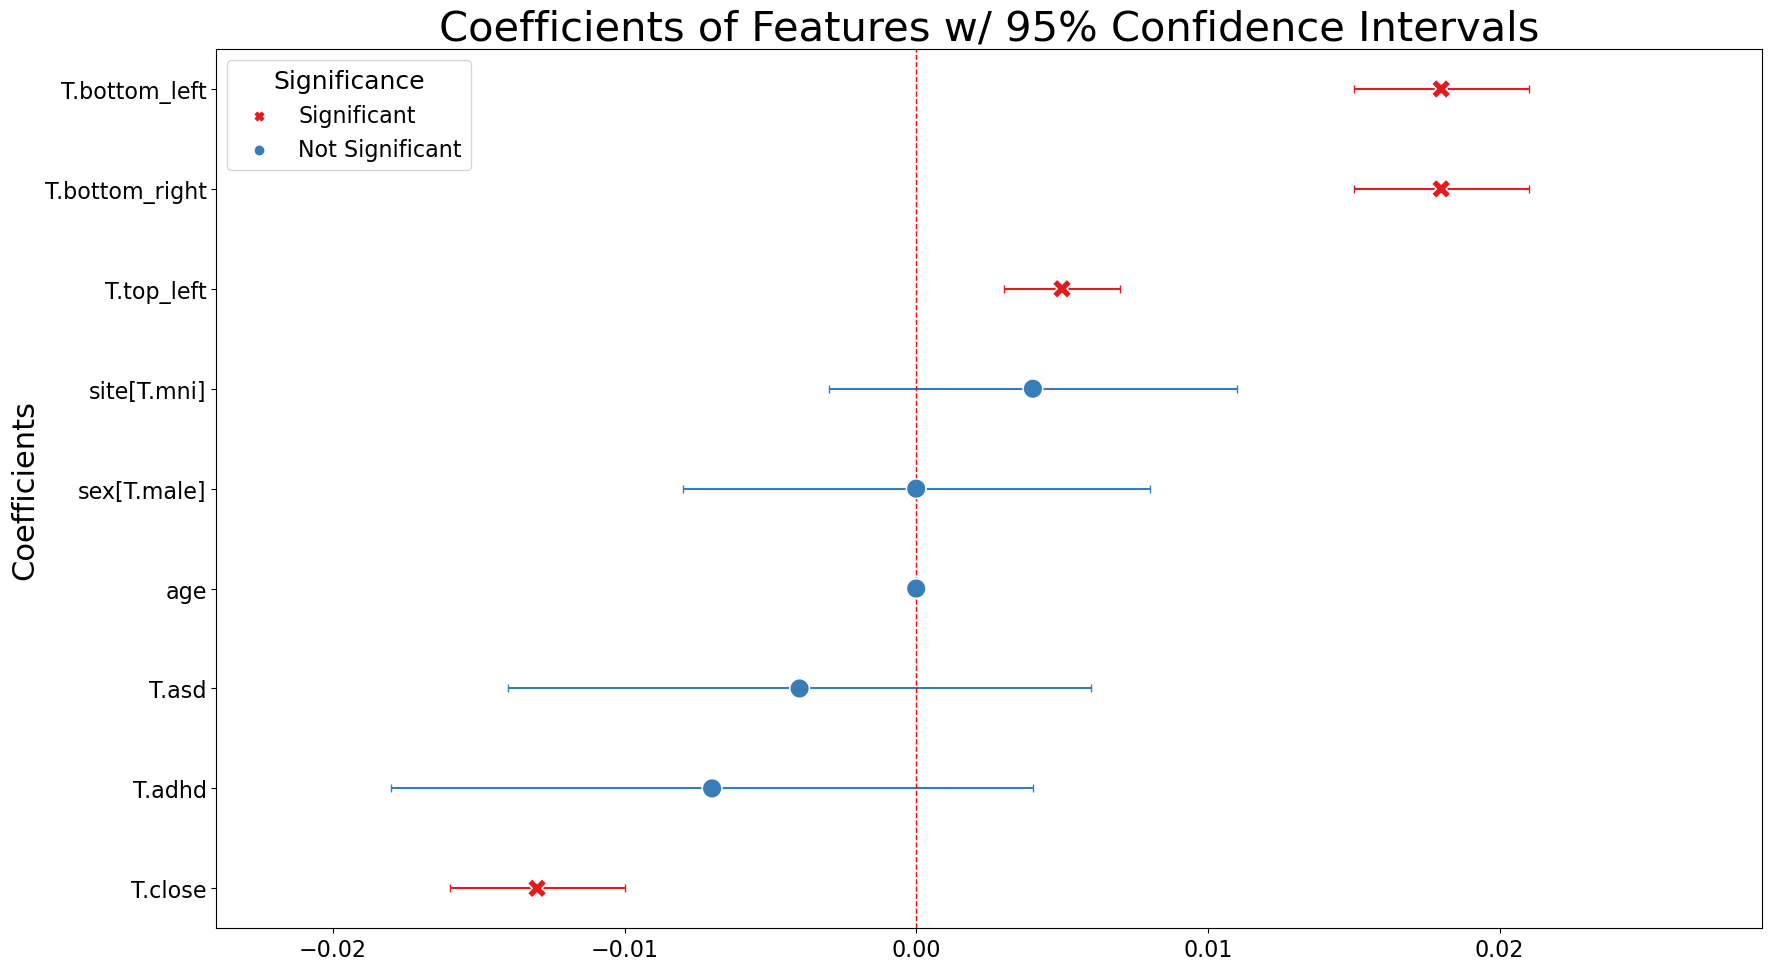

In [117]:
# Test the effects of group and condition on rt while accoutning for sex, age and site

# Create mixed effects model
model_formula = "reciprocal_rt ~C(diagnosis_group, Treatment(reference = 'control'))  + C(quadrant, Treatment(reference = 'top_right')) + age + sex + site"

# Fit the model
model = smf.mixedlm(model_formula, vs_grouped, groups=vs_grouped["subject"],re_formula="~1").fit()

# Print the summary
model_summary = model.summary()
model_summary 
plt.rcParams.update({
    'font.size': 16,       # Base font size for ticks and text
    'axes.titlesize': 30,  # Title font
    'axes.labelsize': 22,  # Axis label font
    'xtick.labelsize': 16, # X-tick font
    'ytick.labelsize': 16, # Y-tick font
    'legend.fontsize': 16, # Legend font
    'legend.title_fontsize': 18  # Legend title font
})
coefplot_gap(model, multiple_models=False, fig_name='Simple Linear')
#nothing matters other than conditions (Faster 13 or 9)